In [1]:
%load_ext autoreload
%autoreload 2

# Analysis 

You can click on the following sections

- <a href="#1parameters">1 parameter</a>
- <a href="#2parameters">2 parameters</a>
- <a href="#3parameters">3 parameters</a>
- <a href="#Nparameters">N parameters</a>

In [2]:
import numpy 
import yaml
import os
import glob
import sys
import random
import seaborn 
import umap
import pandas
import functools
import matplotlib
import h5py

from matplotlib import pyplot, gridspec, lines, patches
from matplotlib.colors import ListedColormap
from skimage import io
from scipy.stats import gaussian_kde
from scipy.spatial import distance
from scipy.signal import argrelmax
from PIL import Image, ImageDraw
from collections import defaultdict
from tqdm.auto import trange, tqdm

from banditopt import algorithms

# Defines constants used across notebook
PATH = "../data"
REGRESSORS_DICT = {
    "sklearn_BayesRidge":algorithms.sklearn_BayesRidge,
    "sklearn_GP":algorithms.sklearn_GP,
}
OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 40.,
        "max" : 180,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 0.5,
    },
    "Squirrel" : {
        "min" : 5.,
        "max" : 40.,
    }
}
BOUNDS = {
    "Resolution" : {
        "min" : -numpy.inf,
        "max" : 100.,
    },
    "SNR" : {
        "min" : 1.,
        "max" : numpy.inf,
    },
    "Bleach" : {
        "min" : -numpy.inf,
        "max" : 0.4,
    },
    "Squirrel" : {
        "min" : -numpy.inf,
        "max" : 15.,
    }    
}

RADAR_OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 0.,
        "max" : 250.,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 1.0,
    },
    "Squirrel" : {
        "min" : 0.,
        "max" : 2.,
    }
}    

%matplotlib inline

No module named 'specpy'
Calling these functions might raise an error.


## Loading and classical analysis

In [27]:
def savefig(fig, ax, savepath, extension="pdf", save_white=False):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        change_figax_color(fig, ax)
        fig.savefig(f"{savepath}_white.{extension}", bbox_inches="tight", transparent=True)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            collection.set_facecolors(new_colors)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()]   
            collection.set_edgecolors(new_colors)

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
    
def scale_obj(y, obj_name):
    """
    Scales the objectives using the scaling function
    
    :param y: A `numpy.ndarray` of the objective value
    :param obj_name: A `str` of the objective name
    """
    return (y - CONFIG["obj_normalization"][obj_name]["min"]) / (CONFIG["obj_normalization"][obj_name]["max"] - CONFIG["obj_normalization"][obj_name]["min"])

def scale_param(X, param_name):
    """
    Scales the parameters using the scaling function
    
    :param X: A `numpy.ndarray` of the parameters
    :param param_name: A `str` of the parameter
    
    :return : A `numpy.ndarray` of the parameters
    """
    m = CONFIG["x_mins"][CONFIG["param_names"].index(param_name)]
    M = CONFIG["x_maxs"][CONFIG["param_names"].index(param_name)]
    return (X - m) / (M - m)

def rescale_obj(y, obj_name):
    """
    Rescales the objectives using the scaling function
    
    :param y: A `numpy.ndarray` of the objective value
    :param obj_name: A `str` of the objective name
    """
    return y * (CONFIG["obj_normalization"][obj_name]["max"] - CONFIG["obj_normalization"][obj_name]["min"]) + CONFIG["obj_normalization"][obj_name]["min"]

def rescale_param(X, param_name):
    """
    Scales the parameters using the scaling function
    
    :param X: A `numpy.ndarray` of the parameters
    :param param_name: A `str` of the parameter
    
    :return : A `numpy.ndarray` of the parameters
    """
    m = CONFIG["x_mins"][CONFIG["param_names"].index(param_name)]
    M = CONFIG["x_maxs"][CONFIG["param_names"].index(param_name)]
    return X * (M - m) + m

def isin_bounds(y, obj_name):
    """
    Verifies wheter the objectives are within the bounds
    
    :param y: A `numpy.ndarray` of the objective values
    :param obj_name: A `str` of the objective name
    
    :return : A `numpy.ndarray` of the parameters
    """
    return numpy.logical_and(y >= BOUNDS[obj_name]["min"], y <= BOUNDS[obj_name]["max"])

def find_peaks_nd(data, min_threshold=0.5):
    """
    Finds the local maximas in a nd `numpy.ndarray`
    
    :param data: A n-dimensional `numpy.ndarray`
    :param min_threshold: A `float` of the relative threshold value
    
    :returns : A `numpy.ndarray` with shape (N, d)
    """
    # Sets a minimal threshold
    data = data * (data > min_threshold * data.max()).astype(int)
    values = []
    for i in range(data.ndim):
        vals = argrelmax(data, order=1, axis=i)
        values.append(set(zip(*vals)))
    out = list(functools.reduce(lambda x, y: x.intersection(y), values))
    return numpy.array(out)

def get_density(X, num_points=50):
    """
    Computes the density of points
    
    :param X: A `dict` of parameters
    
    :returns : A `numpy.ndarray` of the kernel density estimation
    """
    grids = numpy.meshgrid(*[
        numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)], num_points) 
        for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
    ])
    x_grid = numpy.hstack([grid.ravel()[:,numpy.newaxis] for grid in grids])    
    
    # Calculates the kernel density function        
    _X = numpy.concatenate([X[name] for name in CONFIG["param_names"]], axis=-1)
    kernel = gaussian_kde(_X.T)
    kde = kernel(x_grid.T)  
    return kde / kde.max()

def load_data(path, trial=0, scale=False, gridsearch=False):
    """
    Loads the data from the given path
    
    :param path: A `str` of the path
    :param trial: An `int` of the number of path
    
    :returns : A `dict` of the X
               A `dict` of the y
    """
    if os.path.isfile(os.path.join(path, "optim.hdf5")):
        with h5py.File(os.path.join(path, "optim.hdf5"), "r") as file:
            X = file["X"][f"{trial}"][()]
            y = file["y"][f"{trial}"][()]
    else:
        X = numpy.loadtxt(os.path.join(path, f"X_{trial}.csv"), delimiter=",")
        y = numpy.loadtxt(os.path.join(path, f"y_{trial}.csv"), delimiter=",")
    if X.ndim == 1:
        X = X[:, numpy.newaxis]
    X = {
        param_name : scale_param(X[:, sum(NDIMS[:i]) : sum(NDIMS[:i]) + NDIMS[i]], param_name) 
                     if scale else X[:, sum(NDIMS[:i]) : sum(NDIMS[:i]) + NDIMS[i]]
        for i, param_name in enumerate(CONFIG["param_names"])
    }
    y = {
        obj_name : y[:, i]
        for i, obj_name in enumerate(CONFIG["obj_names"])
    }
    return X, y

def load_config(path):
    """
    Loads the configuration file from the given path
    """
    config = yaml.load(open(os.path.join(path, "config.yml"), "r"), Loader=yaml.Loader)
    ndims, param_space_bounds, param_names = [], [], []
    for i, param_name in enumerate(config["param_names"]):
        if (param_name in ["decision_time", "threshold_count"]) and ("RESCue" not in path):
            ndims.append(2)
        elif (param_name in ["ch2_LTh_times", "ch2_LTh_thresholds"]):
            ndims.append(4)
        else:
            ndims.append(1)
        param_space_bounds.extend([[config["x_mins"][i], config["x_maxs"][i]]] * ndims[-1])            
        param_names.extend([param_name] * ndims[-1])
    n_points = [config["n_divs_default"]]*sum(ndims)  
    return config, ndims, param_space_bounds, param_names, n_points, config["nbre_trials"]

def plot_sequence(X, y):
    """
    Plots the sequence of choices
    
    :param X: A `dict` of the selected parameters
    :param y: A `dict` of the objectives
    :param param_name: A `str` of the parameter
    
    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
    """
    fig, axes = pyplot.subplots(1, len(y), figsize=(10, 3))    
    for ax, (obj_name, values) in zip(axes.ravel(), y.items()):
        ax.plot(values)
        ax.set(
            title=obj_name, ylim=(OBJ_PLOT_LIM[obj_name]["min"], OBJ_PLOT_LIM[obj_name]["max"])
        )
    return fig, axes

def plot_mean_sequences(stats):
    """
    Plot the average +/- std of sequences for all repetitions
    
    :params stats: A `dict` with key `sequences`
    
    :returns : A `dict` of created `matplotlib.Figure`
    """
    out = {}
    for obj_name, values in stats["sequences"].items():
        values = numpy.array(values)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)    
        fig, ax = pyplot.subplots(figsize=(3,3))
        x = numpy.arange(len(mean))
        ax.plot(x, mean)
        ax.fill_between(x, mean - std, mean + std, alpha=0.3)
        ax.set(
            xlabel="Total image (count)", 
            ylabel=obj_name,
            ylim=(OBJ_PLOT_LIM[obj_name]["min"], OBJ_PLOT_LIM[obj_name]["max"])
        )
        out[obj_name] = (fig, ax)
    return out

def plot_failures(X, y):
    """
    Plots the given data in 1D
    
    :param X: A `dict` of the selected parameters
    :param y: A `dict` of the objectives
    
    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
               A `numpy.ndarray` of failures
    """
    fig, ax = pyplot.subplots(figsize=(3,3))
    objs = [~isin_bounds(values, obj_name) for obj_name, values in y.items()]
    objs = numpy.cumsum(numpy.any(objs, axis=0))
    ax.plot(numpy.arange(len(objs)), objs, color="tab:blue")
    ax.plot([0, len(objs)], [0, len(objs)], linestyle="dashed", color="black")
    ax.set(
        xlabel="Total image (count)", 
        ylabel="Failure (count)",
        ylim=(0, CONFIG["optim_length"]), xlim=(0, CONFIG["optim_length"])
    )
    return fig, ax, objs

def plot_mean_failures(stats, figax=None):
    """
    Plot the average +/- std of failures for all repetitions
    
    :params stats: A `dict` with key `failures`
    :param figax: (optional) A `tuple` of a `maplotlib.Figure` and a `matplotlib.Axes`    
    
    :returns : A `dict` of created `matplotlib.Figure`
    """
    out = {}
    for key, values in stats["failures"].items():

        values = numpy.array(values)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)

        if isinstance(figax, type(None)):
            fig, ax = pyplot.subplots(figsize=(3, 3), tight_layout=True)
        else:
            fig, ax = figax
            
        x = numpy.arange(len(mean))
        ax.plot(x, mean)
        ax.fill_between(x, mean - std, mean + std, alpha=0.3)
        ax.plot([0, len(x)], [0, len(x)], linestyle="dashed", color="black")
        ax.set(
            xlabel="Total image (count)", 
            ylabel="Failure (count)",
            ylim=(0, CONFIG["optim_length"]), xlim=(0, CONFIG["optim_length"])
        )
        out[key] = (fig, ax)
    return out

def plot_optimal_parameter(X, y, o_params, param_name="p_sted"):
    """
    Plots the cumulative frequency of the number of times the 
    optimal parameter was not selected

    :param X: A `dict` of the selected parameters
    :param y: A `dict` of the objectives
    :param o_params: A `list` of the optimal parameter
    :param param_name: A `str` of the parameter    
    """
    fig, ax = pyplot.subplots(figsize=(3,3))
    out = {}
    for o_param in o_params:
        x = numpy.arange(len(X[param_name]))
        optimal = numpy.cumsum(X[param_name] != o_param)
        ax.plot(x, optimal, label="{:0.4f}".format(o_param))
        out[o_param] = optimal
    ax.set(
        xlim=(0, x.max()),
        ylim=(0, x.max())
    )
    ax.legend()
    return fig, ax, out

def plot_mean_optimal_parameter(stats, figax=None):
    """
    Plots the average cumulative frequency of the number of times the 
    optimal parameter was not selected
    """
    out = {}
    for key, values in stats["optimals"].items():

        values = numpy.array(values)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)

        if isinstance(figax, type(None)):
            fig, ax = pyplot.subplots(figsize=(3, 3), tight_layout=True)
        else:
            fig, ax = figax
            
        x = numpy.arange(len(mean))
        ax.plot(x, mean)
        ax.fill_between(x, mean - std, mean + std, alpha=0.3)
        ax.plot([0, len(x)], [0, len(x)], linestyle="dashed", color="black")
        ax.set(
            xlabel="Total image (count)", 
            ylabel="Failure optimal (count)",
            ylim=(0, CONFIG["optim_length"]), xlim=(0, CONFIG["optim_length"])
        )
        out[key] = (fig, ax)
    return out

def plot_cumulative_std(stats):
    """
    Plots the average cumulative std from a model on the different 
    objectives
    
    :param stats: A `dict` of statisitics
    
    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
    """
    fig, ax = pyplot.subplots(figsize=(3,3))
    for model_name, model_stats in stats.items():        
        ratios = []
        for i, (obj_name, values) in enumerate(model_stats["sequences"].items()):
            values = numpy.array(values)
            values = scale_obj(values, obj_name=obj_name)
            mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)
            # Represents the cummulated value of STD if agent did not learn
            maximal_std_value = numpy.mean(std[:5]) * len(std)
            ratio = numpy.cumsum(std) / maximal_std_value
            ratios.append(ratio)
        
        ratio = numpy.mean(ratios, axis=0)
        ax.plot(ratio, label=model_name.split("_")[-1])
    ax.plot([0, CONFIG["optim_length"]], [0, 1], color="black", linestyle="dashed")        
    ax.set(
        ylim=(0, 1), xlim=(0, CONFIG["optim_length"]),
        xlabel="Total image (count)",
        ylabel="% cummulated STD"
    )
    ax.legend()    
    return fig, ax
    
def plot_mean_cumulative_std(stats):
    """
    Plots the average cumulative std of the different models 
    on the same graph
    
    :param stats: A `dict` of statisitics
    
    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
    """    
    fig, ax = pyplot.subplots(figsize=(3,3))
    cmap = pyplot.cm.get_cmap("tab10")
    ratios = []
    for i, (obj_name, values) in enumerate(stats["sequences"].items()):
        
        values = numpy.array(values)
        values = scale_obj(values, obj_name=obj_name)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)
    
        # Represents the cummulated value of STD if agent did not learn
        maximal_std_value = numpy.mean(std[:5]) * CONFIG["optim_length"]
        ratio = numpy.cumsum(std) / maximal_std_value
        ax.plot(ratio, label=obj_name, color=cmap(i), alpha=0.3)
        ratios.append(ratio)
    ax.plot([0, CONFIG["optim_length"]], [0, 1], color="black", linestyle="dashed")
    ax.plot(numpy.mean(ratios, axis=0), color="black", linestyle="solid", label="Avg.")
    ax.set(
        ylim=(0, 1), xlim=(0, CONFIG["optim_length"]),
        xlabel="Total image (count)",
        ylabel="% cummulated STD"
    )
    ax.legend()
    return fig, ax

def dist(x, y):
    """
    Calculates the distance between `x` and `y` in n-dimensions
    
    :param x: A `numpy.ndarray` of size (M, n)
    :param y: A `numpy.ndarray` of size (M, n)
    
    :returns A `numpy.ndarray` of the size (M)
    """
    x, y = map(numpy.array, (x, y))
    if x.ndim == 1: 
        x = x[:, numpy.newaxis]
    if y.ndim == 1:
        y = y[:, numpy.newaxis]
    return numpy.sqrt(numpy.sum((x - y) ** 2, axis=1))
    
def plot_mean_param_sequences_dist(stats):
    """
    Plots the selected distances between two sampled parameters
    
    :param stats: A `dict` of the stats
    """
    out = {}
    
    values = numpy.array([values for key, values in stats["param_sequences"].items()])
    
    distances = []
    for i in range(values.shape[-1] - 1):
        dataA = values[:, :, i].T
        dataB = values[:, :, i + 1].T
        distances.append(dist(dataA, dataB))
    distances = numpy.array(distances)
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    mean, std = numpy.mean(distances, axis=1), numpy.std(distances, axis=1)
    mean, std = mean / (mean[0] + 1e-9), std / (mean[0] + 1e-9)
    x = numpy.arange(len(mean))
    ax.plot(x, mean)
    ax.fill_between(x, mean - std, mean + std, alpha=0.3)
    ax.set(
        xlabel="Total image (count)", ylabel="Normalized distance (optim)",
        ylim=(0, None), xlim=(0, CONFIG["optim_length"])
    )
    out["optim"] = (fig, ax)
    
    distances = []
    for i in range(values.shape[-1]):
        dataA = values[:, :, i].T
        d = distance.cdist(dataA, dataA)
#         distances.append
        mask = ~numpy.eye(d.shape[0], dtype=bool) # everything apart from diagonal
        d = d[mask]
        distances.append((d.mean(), d.std()))
    distances = numpy.array(distances)    
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    mean, std = distances[:, 0], distances[:, 1]
    mean, std = mean / (mean[0] + 1e-9), std / (mean[0] + 1e-9)
    x = numpy.arange(len(mean))
    ax.plot(x, mean)
    ax.fill_between(x, mean - std, mean + std, alpha=0.3)
    ax.set(
        xlabel="Total image (count)", ylabel="Normalized distance (trial)",
        ylim=(0, None)
    )    
    out["trial"] = (fig, ax)
    return out

def plot_data_1d(X, y, param_name):
    """
    Plots the given data in 1D
    
    :param X: A `dict` of the selected parameters
    :param y: A `dict` of the objectives
    :param param_name: A `str` of the parameter    
    """
    Xdf = pandas.DataFrame.from_dict(
        {key : values.ravel() for key, values in X.items()}
    )

    out, mean_regression = {}, {}
    for obj_name, values in y.items():
        fig, ax = pyplot.subplots(figsize=(3,3))
        
        args = CONFIG["regressor_args"]["default"].copy()
        args["param_space_bounds"] = PARAM_SPACE_BOUNDS
        for key, value in CONFIG["regressor_args"][obj_name].items():
            args[key] = value
        sampler = algorithms.TS_sampler(REGRESSORS_DICT[CONFIG["regressor_name"]](**args))

        sampler.update(X[param_name], values)
        grids = numpy.meshgrid(
            numpy.linspace(
                CONFIG["x_mins"][CONFIG["param_names"].index(param_name)], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(param_name)]
            )
        )
        x_grid = numpy.stack(grids, axis=-1)
        if CONFIG["regressor_name"] == "sklearn_BayesRidge":
            mean, _, std = sampler.regressor.get_mean_std(x_grid, return_withnoise=True)
        else:
            mean, std = sampler.regressor.get_mean_std(x_grid)

        twinax = ax.twinx()
        seaborn.kdeplot(
            data=Xdf, x=param_name, ax=twinax, clip=[Xdf[param_name].min(), Xdf[param_name].max()], color="Black")
        ax.scatter(X[param_name], values, color="black")
        ax.plot(x_grid[:, 0], mean, color="tab:blue")
        ax.fill_between(x_grid[:, 0], mean - std, mean + std, color="tab:blue", alpha=0.3)
        ax.set(
            title=obj_name, xlabel=param_name, 
            ylim=(OBJ_PLOT_LIM[obj_name]["min"], OBJ_PLOT_LIM[obj_name]["max"])
        )
        mean_regression[obj_name] = mean
        
        out[obj_name] = (fig, ax)
        
    # Calculates the kernel density function
    x = numpy.linspace(
        CONFIG["x_mins"][CONFIG["param_names"].index(param_name)], 
        CONFIG["x_maxs"][CONFIG["param_names"].index(param_name)]
    )
    kernel = gaussian_kde(X[param_name].T)
    kde = kernel(x)
        
    return out, mean_regression, kde / kde.max()

def plot_data_2d(X, y):
    """
    Plots the given data in 2D
    
    :param X: A `dict` of the selected parameters
    :param y: A `dict` of the objectives
    """
    out = {}
    mean_regression = {}
    for obj_name, values in y.items():
        fig, ax = pyplot.subplots(figsize=(3,3))
#         sc = ax.scatter(*(X[param_name].T.astype(int)), markerstyle="z")
#         fig.colorbar(sc, ax=ax)
        
        # Converts to DataFrame to use with seaborn
        Xdf = pandas.DataFrame.from_dict({
            "{}_{}".format(param_name, i) : X[param_name][:, i] for ndim, param_name in zip(NDIMS, CONFIG["param_names"]) for i in range(ndim)
        })
        keys = {axis : key for axis, key in zip(["x", "y"], Xdf.keys())}
        seaborn.kdeplot(data=Xdf, **keys, ax=ax, color="Black")
    
        args = CONFIG["regressor_args"]["default"].copy()
        args["param_space_bounds"] = PARAM_SPACE_BOUNDS        
        for key, value in CONFIG["regressor_args"][obj_name].items():
            args[key] = value
        sampler = algorithms.TS_sampler(REGRESSORS_DICT[CONFIG["regressor_name"]](**args))

        _X = numpy.concatenate([X[name] for name in CONFIG["param_names"]], axis=-1)
        sampler.update(_X, values)
        
        # Creates the grid for future use
        grids = numpy.meshgrid(*[
            numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)]) 
            for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
        ])
        x_grid = numpy.hstack([grid.ravel()[:,numpy.newaxis] for grid in grids])

        if CONFIG["regressor_name"] == "sklearn_BayesRidge":
            mean, _, std = sampler.regressor.get_mean_std(x_grid, return_withnoise=True)
        else:
            mean, std = sampler.regressor.get_mean_std(x_grid)
        im = ax.imshow(
            mean.reshape(grids[0].shape), origin="lower",
            extent=(
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[1])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[1])]
            ),
            vmin=OBJ_PLOT_LIM[obj_name]["min"], 
            vmax=OBJ_PLOT_LIM[obj_name]["max"], 
            cmap="Blues"
        )
        fig.colorbar(im, ax=ax)
    
        ax.set(
            title="-".join(PARAM_NAMES),
            xlim=(CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[0])], CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[0])]),
#             xlabel=CONFIG["param_names"][0],
            ylim=(CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[1])], CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[1])]),
#             ylabel=CONFIG["param_names"][1],
        )

        ax.set(
            title=obj_name
        )
        out[obj_name] = (fig, ax)
        mean_regression[obj_name] = mean
        
    # Calculates the kernel density function        
    _X = numpy.concatenate([X[name] for name in CONFIG["param_names"]], axis=-1)
    kernel = gaussian_kde(_X.T)
    kde = kernel(x_grid.T)
        
    return out, mean_regression, kde / kde.max()

def plot_data_3d(X, y, param_name, max_axes=5):
    """
    Plots the given data in 3D
    
    :param X: A `dict` of the selected parameters
    :param y: A `dict` of the objectives
    :param param_name: A `str` of the parameter for the 1d
    """
    numpy.random.seed(42)
    
    # Creates the 2D parameter names
    param_name_2d = [pname for pname in PARAM_NAMES if pname != param_name]
    bins = numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(param_name)], CONFIG["x_maxs"][CONFIG["param_names"].index(param_name)], N_POINTS[CONFIG["param_names"].index(param_name)])
    digitized = numpy.digitize(
        X[param_name],
        bins=bins
    )
    unique_values, counts = numpy.unique(digitized, return_counts=True)
    unique_values = unique_values[counts >= 3]
    if len(unique_values) > max_axes:
        unique_values = numpy.random.choice(unique_values, max_axes, replace=False)
    unique_values = numpy.sort(unique_values)

    out = {}
    for obj_name, values in y.items():

        args = CONFIG["regressor_args"]["default"].copy()
        args["param_space_bounds"] = PARAM_SPACE_BOUNDS
        for key, val in CONFIG["regressor_args"][obj_name].items():
            args[key] = val        
        sampler = algorithms.TS_sampler(REGRESSORS_DICT[CONFIG["regressor_name"]](**args))
        
        # Creates the input and target
        _X = numpy.concatenate([X[name] for name in CONFIG["param_names"]], axis=-1)
#         values = scale_obj(values, obj_name)
        
        # Updates the sampler 
        sampler.update(_X, values)
    
        # Creates the grid for future use
        grids = numpy.meshgrid(*[
            numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)], N_POINTS[CONFIG["param_names"].index(pname)]) 
            for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
        ])
        x_grid = numpy.hstack([grid.ravel()[:,numpy.newaxis] for grid in grids])
        
        fig = pyplot.figure(figsize=(10, 3))
        gs = gridspec.GridSpec(1, len(unique_values) + 1, width_ratios=[len(unique_values) for _ in range(len(unique_values))] + [1])
        axes = numpy.array([fig.add_subplot(_gs) for _gs in gs])

        for ax, value in zip(axes.ravel(), unique_values):
            # Plots the points 
            where = numpy.argwhere(digitized == value).ravel()
            _X = numpy.concatenate([X[name] for name in set(param_name_2d)], axis=-1)
            xy = _X[where]
#             seaborn.kdeplot(*xy.T, ax=ax, color="Black", levels=5)
            ax.scatter(*xy.T, color="black")
        
            # Plots the learned distribution
            where = x_grid[:, 0] == bins[value]
            if CONFIG["regressor_name"] == "sklearn_BayesRidge":
                mean, _, std = sampler.regressor.get_mean_std(x_grid[where], return_withnoise=True)
            else:
                mean, std = sampler.regressor.get_mean_std(x_grid[where])
#             mean, std = rescale_obj(mean, obj_name), rescale_obj(std, obj_name)

            im = ax.imshow(
                mean.reshape(CONFIG["n_divs_default"], CONFIG["n_divs_default"]), origin="lower",
                extent=(
                    CONFIG["x_mins"][CONFIG["param_names"].index(param_name_2d[0])], 
                    CONFIG["x_maxs"][CONFIG["param_names"].index(param_name_2d[0])], 
                    CONFIG["x_mins"][CONFIG["param_names"].index(param_name_2d[1])], 
                    CONFIG["x_maxs"][CONFIG["param_names"].index(param_name_2d[1])]
                ),
                vmin=OBJ_PLOT_LIM[obj_name]["min"], 
                vmax=OBJ_PLOT_LIM[obj_name]["max"], 
#                 vmin=0, vmax=1,
                cmap="Blues"
            )

            mx, Mx = CONFIG["x_mins"][CONFIG["param_names"].index(param_name_2d[0])], CONFIG["x_maxs"][CONFIG["param_names"].index(param_name_2d[0])]
            my, My = CONFIG["x_mins"][CONFIG["param_names"].index(param_name_2d[1])], CONFIG["x_maxs"][CONFIG["param_names"].index(param_name_2d[1])]            
            ax.set(
                title = "{:0.4f} mW".format(bins[value] * 1e+3),
                xlim = (mx, Mx), ylim=(my, My)
            )            
        gs.tight_layout(fig)
        cbar = fig.colorbar(im, cax=axes[-1])
        cbar.set_label(obj_name)

        out[obj_name] = (fig, axes)

    grids= numpy.meshgrid(*[
        numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)]) 
        for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
    ])
    x_grid = numpy.hstack([grid.ravel()[:,numpy.newaxis] for grid in grids])    
    
    # Calculates the kernel density function        
    _X = numpy.concatenate([X[name] for name in CONFIG["param_names"]], axis=-1)
    kernel = gaussian_kde(_X.T)
    kde = kernel(x_grid.T)        
        
    return out, unique_values, kde / kde.max()

## Montage utilitaries

In [33]:
def show_N_images(X, y, image_path, ncols=5, vmin=0, vmax=250, colormap="hot",
                  image_indices=None):
    """
    Creates a montage of the first N and last N images
    """
    h, w = (256, 256)
    nrows = 1
    
    if isinstance(image_indices, type(None)):
        image_indices = numpy.arange(CONFIG["optim_length"])
    
    out = {}
    
    # N first images
    collage = Image.new("RGBA", (ncols * w, nrows * h))
    for i, index in enumerate(image_indices[:ncols]):
        if isinstance(image_path, str):
            image = io.imread(os.path.join(image_path, "{}.tif".format(i)))
        else:
            image = image_path[index]
            if image.ndim == 3:
                image = image[-1]
                
        # Normalize image
        if isinstance(vmax, type(None)):
            image = numpy.clip((image - image.min()) / (0.75 * (image.max() - image.min() + 1e-3)), 0, 1)
        else:
            image = numpy.maximum(image, vmin)
            image = numpy.minimum(image, vmax)
            image = (image - vmin) / (vmax - vmin)        
        
        # Changes the colormap and converts to PIL
        cmap = pyplot.cm.get_cmap(colormap)
        image = (cmap(image) * 255).astype(numpy.uint8) # Converts to uint8
        pil_img = Image.fromarray(image, "RGBA")
        # Resizes the image
        pil_img = pil_img.resize(size=(w, h), resample=Image.BILINEAR)
        collage.paste(pil_img, (i * w, 0))     
        
    # Draws white line on image
    draw = ImageDraw.Draw(collage)
    linewidth = 2
    for j in range(nrows + 1):
        draw.line([(0, min(j * h, collage.size[1] - linewidth)), (collage.size[0] + w, min(j * h, collage.size[1] - linewidth))], 
                  fill="rgb(255, 255, 255)", width=linewidth)
    for i in range(ncols + 1):
        draw.line([(min(i * w, collage.size[0] - linewidth), 0), (min(i * w, collage.size[0] - linewidth), collage.size[1] + h)], 
                  fill="rgb(255, 255, 255)", width=linewidth)
    
    out["Nfirst"] = collage
    
    
    # N first images
    collage = Image.new("RGBA", (ncols * w, nrows * h))
    for i, index in enumerate(image_indices[-1*ncols:]):
        if isinstance(image_path, str):
            image = io.imread(os.path.join(image_path, "{}.tif".format(i)))
        else:
            image = image_path[index]      
            if image.ndim == 3:
                image = image[-1]
                
        # Normalize image
        if isinstance(vmax, type(None)):
            image = numpy.clip((image - image.min()) / (0.75 * (image.max() - image.min() + 1e-3)), 0, 1)
        else:
            image = numpy.maximum(image, vmin)
            image = numpy.minimum(image, vmax)
            image = (image - vmin) / (vmax - vmin)        
        
        # Changes the colormap and converts to PIL
        cmap = pyplot.cm.get_cmap(colormap)
        image = (cmap(image) * 255).astype(numpy.uint8) # Converts to uint8
        pil_img = Image.fromarray(image, "RGBA")
        # Resizes the image
        pil_img = pil_img.resize(size=(w, h), resample=Image.BILINEAR)
        collage.paste(pil_img, (i * w, 0))     
        
    # Draws white line on image
    draw = ImageDraw.Draw(collage)
    linewidth = 2
    for j in range(nrows + 1):
        draw.line([(0, min(j * h, collage.size[1] - linewidth)), (collage.size[0] + w, min(j * h, collage.size[1] - linewidth))], 
                  fill="rgb(255, 255, 255)", width=linewidth)
    for i in range(ncols + 1):
        draw.line([(min(i * w, collage.size[0] - linewidth), 0), (min(i * w, collage.size[0] - linewidth), collage.size[1] + h)], 
                  fill="rgb(255, 255, 255)", width=linewidth)
    
    out["Nlast"] = collage
        
    return out
        
def show_montage(X, y, image_path, ncols=10, nrows=10,
                    vmin=0, vmax=250, colormap="hot", image_indices=None,
                    rm_param=[]):
    """
    Creates a 2d montage from the scores
    """
    random.seed(42)
    
    if isinstance(image_indices, type(None)):
        image_indices = numpy.arange(CONFIG["optim_length"])
    
    h, w = (50, 50)
    collage = Image.new("RGBA", (ncols * w, nrows * h))
    
    xmin = [CONFIG["x_mins"][CONFIG["param_names"].index(param_name)] for param_name in PARAM_NAMES if param_name not in rm_param]
    xmax = [CONFIG["x_maxs"][CONFIG["param_names"].index(param_name)] for param_name in PARAM_NAMES if param_name not in rm_param]
    xmin, xmax = map(numpy.array, (xmin, xmax))
    dx, dy = (xmax - xmin) / numpy.array([ncols, nrows])
    sampled_images = []
    
    data = numpy.concatenate([X[name] for name in CONFIG["param_names"] if name not in rm_param], axis=-1)
    for j in range(nrows):
        for i in range(ncols):
#             data = X[param_name]
            where = (data >= numpy.array([i * dx, j * dy])) * (data <= numpy.array([i * dx + 1.1*dx, j * dy + 1.1*dy]))
            indices = numpy.argwhere(numpy.all(where, axis=1)).ravel()
            
            # Skip image 
            if len(indices) < 1:
                continue
            
            # Asserts an image is not sampled twice
            valid = []
            for index in indices:
                if index not in sampled_images:
                    valid.append(index)
            if len(valid) < 1:
                continue
            
            # Could be changed to sample with highest value
            index = random.choice(valid)
            if isinstance(image_path, str):
                image = io.imread(os.path.join(image_path, "{}.tif".format(image_indices[index])))
            else:
                image = image_path[image_indices[index]]
            image = numpy.maximum(image, vmin)
            image = numpy.minimum(image, vmax)
            image = (image - vmin) / (vmax - vmin)
            
            # Changes the colormap and converts to PIL
            cmap = pyplot.cm.get_cmap(colormap)
            image = (cmap(image) * 255).astype(numpy.uint8) # Converts to uint8
            pil_img = Image.fromarray(image, "RGBA")
            # Resizes the image
            pil_img = pil_img.resize(size=(w, h), resample=Image.BILINEAR)
            # Reverses the rows
            collage.paste(pil_img, (i * w, (nrows - (j + 1)) * h))
    
    # Draws white line on image
    draw = ImageDraw.Draw(collage)
    linewidth = 2
    for j in range(nrows + 1):
        draw.line([(0, min(j * h, collage.size[1] - linewidth)), (collage.size[0] + w, min(j * h, collage.size[1] - linewidth))], 
                  fill="rgb(255, 255, 255)", width=linewidth)
    for i in range(ncols + 1):
        draw.line([(min(i * w, collage.size[0] - linewidth), 0), (min(i * w, collage.size[0] - linewidth), collage.size[1] + h)], 
                  fill="rgb(255, 255, 255)", width=linewidth)
        
    return collage

def filterdict(X, y, filter_key, filter_value):
    """
    Filters a dict with a specific key:value
    
    :param X: A `dict` of the parameters
    :param y: A `dict` of the objectives
    :filter_key: A `str` of the parameter name
    :filter_value: A (`float` or `int`) of the parameter value
    
    :returns : A `dict` of the filtered parameters
               A `dict` of the filtered objectives
               A `numpy.ndarray` of the indices
    """
    X_out, y_out = {}, {}
    where = (X[filter_key] == filter_value).ravel()
    for key, values in X.items():
        X_out[key] = values[where]
    for key, values in y.items():
        y_out[key] = values[where]
    return X_out, y_out, numpy.argwhere(where).ravel()


## Multidimensional analysis

In [5]:
def plot_umap_points(X, y):
    """
    Plots a multidimensional umap analysis
    
    :param X: A `dict` of parameters
    :param y: A `dict` of objectives
    
    :returns : A `umap.UMAP` trained
               A `numpy.ndarray` of the transformed data
               A `matplotlib.Figure`
               A `matplotlib.Axes`
    """
    # Combines all data
    all_data = numpy.concatenate((
            numpy.concatenate([scale_param(X[param_name], param_name) for param_name in CONFIG["param_names"]], axis=1), 
            numpy.concatenate([scale_obj(y[obj_name][:, numpy.newaxis], obj_name) for obj_name in CONFIG["obj_names"]], axis=-1)
        ), 
        axis=-1
    )

    # Creates the mapper
    random.seed(42)
    numpy.random.seed(42)
    mapper = umap.UMAP(n_neighbors=15, min_dist=1., random_state=42).fit(all_data)
    X_transformed = mapper.transform(all_data)

    # Plots the results
    fig, axes = pyplot.subplots(1, len(y), figsize=(10,3), tight_layout=True, sharex=True, sharey=True)
    for ax, (obj_name, values) in zip(axes.ravel(), y.items()):
        sc = ax.scatter(
            *X_transformed.T, c=values, alpha=1., cmap="magma", linewidth=1, edgecolor="black", s=40,
            vmin=OBJ_PLOT_LIM[obj_name]["min"], vmax=OBJ_PLOT_LIM[obj_name]["max"],    
        )
        ax.set(
            title = obj_name,
            xlim=(X_transformed.min(axis=0)[0], X_transformed.max(axis=0)[0]),
            ylim=(X_transformed.min(axis=0)[1], X_transformed.max(axis=0)[1])        
        )
        fig.colorbar(sc, ax=ax)   
    return mapper, X_transformed, fig, axes

def plot_invumap_points(mapper, X_transformed, X, y):
    """
    
    """
    # Inverts the complete grid of points
    grids = numpy.meshgrid(*[
        numpy.linspace(m, M) for m, M in zip(X_transformed.min(axis=0), X_transformed.max(axis=0))
    ])
    x_grid = numpy.stack(grids).reshape(len(grids), -1)
    X_inv = mapper.inverse_transform(x_grid.T)
    X_inv = numpy.transpose(X_inv.reshape(*grids[0].shape, -1), axes=(2, 0, 1))

    out = {}
    fig, axes = pyplot.subplots(1, 3, figsize=(10,3), tight_layout=True, sharex=True, sharey=True)
    for ax, x, (obj_name, values) in zip(axes.ravel(), X_inv[-1*len(y):], y.items()):
        x = rescale_obj(x, obj_name)
        xx, yy = grids
        im = ax.imshow(
            x, cmap="magma",
            vmin=OBJ_PLOT_LIM[obj_name]["min"], vmax=OBJ_PLOT_LIM[obj_name]["max"],
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            origin="lower", aspect="equal"
        )
        ax.set_title(obj_name)
        fig.colorbar(im, ax=ax)
    out["objectives"] = (fig, axes)
        
    out["params"] = {}
    for i, (x, bounds, param_name) in enumerate(zip(X_inv[:-1*len(y)], PARAM_SPACE_BOUNDS, PARAM_NAMES)):
        x = rescale_param(x, param_name)    
        fig, ax = pyplot.subplots(figsize=(3, 3), tight_layout=True)
        xx, yy = grids
        im = ax.imshow(
            x, cmap="magma",
            vmin=min(bounds), vmax=max(bounds),
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            origin="lower", aspect="equal"
        )
        ax.set_title(param_name)
        fig.colorbar(im, ax=ax)
        out["params"]["{}-{}".format(param_name, i)] = (fig,ax)

    return out

def plot_invumap_model(X, y, num_points=4):
    ys = []
    for obj_name, values in y.items():

        args = CONFIG["regressor_args"]["default"].copy()
        args["param_space_bounds"] = PARAM_SPACE_BOUNDS
        for key, val in CONFIG["regressor_args"][obj_name].items():
            args[key] = val        
        sampler = algorithms.TS_sampler(REGRESSORS_DICT[CONFIG["regressor_name"]](**args))

        # Creates the input and target
        _X = numpy.concatenate([X[name] for name in CONFIG["param_names"]], axis=-1)
        values = scale_obj(values, obj_name)

        # Updates the sampler 
        sampler.update(_X, values)

        # Creates the grid to sample the data from
        grids = numpy.meshgrid(*[
            numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)], num_points) 
            for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
        ])
        x_grid = numpy.hstack([grid.ravel()[:,numpy.newaxis] for grid in grids])

        # Samples from the trained model
        if CONFIG["regressor_name"] == "sklearn_BayesRidge":
            mean, _, std = sampler.regressor.get_mean_std(x_grid, return_withnoise=True)
        else:
            mean, std = sampler.regressor.get_mean_std(x_grid)
        # Clips value to avoid very high sampled values
        mean = numpy.clip(mean, 0, values.max())

        ys.append(mean)

    # Creates a grid from 0 to 1 in all dimensions
    grids = numpy.meshgrid(*[
        numpy.linspace(0, 1, num_points) 
        for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
    ])
    x_grid = numpy.hstack([grid.ravel()[:,numpy.newaxis] for grid in grids])
    
    # Associates the grid of [0, 1] with the corresponding sampled value
    all_data = numpy.concatenate((
            x_grid, 
            numpy.stack(ys, axis=-1)
        ), 
        axis=-1
    )

    # Creates the umap and fits the data
    random.seed(42)
    numpy.random.seed(42)
    mapper = umap.UMAP(n_neighbors=15, min_dist=1., random_state=42, verbose=0).fit(all_data)
    X_transformed = mapper.transform(all_data)
    
    # Creates a grid of points in the umap embedding
    grids = numpy.meshgrid(*[
        numpy.linspace(m, M) for m, M in zip(X_transformed.min(axis=0), X_transformed.max(axis=0))
    ])
    x_grid = numpy.stack(grids).reshape(len(grids), -1)
    X_inv = mapper.inverse_transform(x_grid.T)
    X_inv = numpy.transpose(X_inv.reshape(*grids[0].shape, -1), axes=(2, 0, 1))
    
    out = {}
    fig, axes = pyplot.subplots(1, 3, figsize=(10,3), tight_layout=True, sharex=True, sharey=True)
    for ax, x, (obj_name, values) in zip(axes.ravel(), X_inv[-1 * len(y):], y.items()):
        xx, yy = grids
        cmap = pyplot.cm.get_cmap("magma", 256)
        new_cmap = cmap(numpy.linspace(0, 1, 256))
        if obj_name == "Resolution":
            m = (60 - OBJ_PLOT_LIM[obj_name]["min"]) / (OBJ_PLOT_LIM[obj_name]["max"] - OBJ_PLOT_LIM[obj_name]["min"])
            M = (100 - OBJ_PLOT_LIM[obj_name]["min"]) / (OBJ_PLOT_LIM[obj_name]["max"] - OBJ_PLOT_LIM[obj_name]["min"])        
            new_cmap[int(m * 256) : int(M * 256)] = numpy.array([1, 1, 0, 1])
        if obj_name == "Bleach":
            m = (0.02 - OBJ_PLOT_LIM[obj_name]["min"]) / (OBJ_PLOT_LIM[obj_name]["max"] - OBJ_PLOT_LIM[obj_name]["min"])
            M = (0.1 - OBJ_PLOT_LIM[obj_name]["min"]) / (OBJ_PLOT_LIM[obj_name]["max"] - OBJ_PLOT_LIM[obj_name]["min"])        
            new_cmap[int(m * 256) : int(M * 256)] = numpy.array([1, 1, 0, 1])        
        if obj_name == "Squirrel":
            m = (0 - OBJ_PLOT_LIM[obj_name]["min"]) / (OBJ_PLOT_LIM[obj_name]["max"] - OBJ_PLOT_LIM[obj_name]["min"])
            M = (20 - OBJ_PLOT_LIM[obj_name]["min"]) / (OBJ_PLOT_LIM[obj_name]["max"] - OBJ_PLOT_LIM[obj_name]["min"])        
            new_cmap[max(0, int(m * 256)) : min(int(M * 256), 256)] = numpy.array([1, 1, 0, 1])                
        new_cmap = ListedColormap(new_cmap)

        im = ax.imshow(
            rescale_obj(x, obj_name), 
            cmap=cmap,
            vmin=OBJ_PLOT_LIM[obj_name]["min"], vmax=OBJ_PLOT_LIM[obj_name]["max"],
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            origin="lower", aspect="equal"
        )
        ax.set_title(obj_name)
        fig.colorbar(im, ax=ax)    
    out["objectives"] = (fig, axes)

    out["params"] = {}
    for i, (x, bounds, param_name) in enumerate(zip(X_inv[:-1 * len(y)], PARAM_SPACE_BOUNDS, PARAM_NAMES)):
        fig, ax = pyplot.subplots(figsize=(3,3), tight_layout=True)
        xx, yy = grids
        im = ax.imshow(
            rescale_param(x, param_name), 
            cmap="magma",
            vmin=min(bounds), vmax=max(bounds), 
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            origin="lower", aspect="equal"
        )
        ax.set_title(param_name)
        fig.colorbar(im, ax=ax)
        out["params"]["{}-{}".format(param_name, i)] = (fig, ax)
        
    return out


# Radar charts

In [22]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = numpy.linspace(0, 2*numpy.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
        
        def fill_between(self, *args, **kwargs):
            lines = super().fill_between(*args, **kwargs)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = numpy.append(x, x[0])
                y = numpy.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(numpy.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def plot_mean_radar_chart(stats, N=50):
    """
    Plots the mean radar chart of a specific model
    """
    def _scale_obj(value, key):
        return (value - RADAR_OBJ_PLOT_LIM[key]["min"]) / (RADAR_OBJ_PLOT_LIM[key]["max"] - RADAR_OBJ_PLOT_LIM[key]["min"])
    
    out = {
        "sequences" : None,
        "param_sequences" : None
    }
    
    # Objectives
    thetas = radar_factory(len(stats["sequences"]), "circle")

    means, stds = [], []
    for i, (key, values) in enumerate(stats["sequences"].items()):
        values = _scale_obj(numpy.array(values), key)      
        means.append(numpy.mean(values, axis=0))
        stds.append(numpy.std(values, axis=0))
    means = numpy.array(means)
    stds = numpy.array(stds)
    
    fig, axes = pyplot.subplots(1, 2, figsize=(6, 3), subplot_kw=dict(projection='radar'))
    cmap = pyplot.cm.get_cmap("cool")
    idx = list(range(0, CONFIG["optim_length"], N)) + [CONFIG["optim_length"] - 1]         
    for i in idx :
        axes[0].plot(thetas, means[:, min(i, len(means) - 1)], c=cmap(i / CONFIG["optim_length"]), alpha=1, linewidth=2)
        axes[1].plot(thetas, stds[:, min(i, len(means) - 1)], c=cmap(i / CONFIG["optim_length"]), alpha=1, linewidth=2)
    for ax in axes.ravel():
        ax.set_varlabels(list(stats["sequences"].keys()))
        ax.set_rgrids(numpy.linspace(0, 1, 11), labels=[])
        ax.set_rmax(1.)
    
    out["sequences"] = (fig, axes)
        
    # Parameters
    thetas = radar_factory(len(stats["param_sequences"]), "circle")

    means, stds = [], []
    for i, (key, values) in enumerate(stats["param_sequences"].items()):
        values = scale_param(numpy.array(values), key.split("-")[0])
        means.append(numpy.mean(values, axis=0))
        stds.append(numpy.std(values, axis=0))
    means = numpy.array(means)
    stds = numpy.array(stds)
    
    fig, axes = pyplot.subplots(1, 2, figsize=(6, 3), subplot_kw=dict(projection='radar'))
    cmap = pyplot.cm.get_cmap("cool")
    idx = list(range(0, CONFIG["optim_length"], N)) + [CONFIG["optim_length"] - 1]
    for i in idx :
        axes[0].plot(thetas, means[:, min(i, len(means) - 1)], c=cmap(i / CONFIG["optim_length"]), alpha=1, linewidth=2)
        axes[1].plot(thetas, stds[:, min(i, len(means) - 1)], c=cmap(i / CONFIG["optim_length"]), alpha=1, linewidth=2)
#         ax.fill_between(thetas, means[:, i] - stds[:, i], means[:, i] + stds[:, i], color=cmap(i / CONFIG["optim_length"]), alpha=0.1)
    for ax in axes.ravel():
        ax.set_varlabels(list(stats["param_sequences"].keys()))
        rgrid = [0, 0.25, 0.5, 0.75, 1.]
        labels = [r if r in [0.25, 0.5, 0.75] else "" for r in rgrid]
        ax.set_rgrids(rgrid, labels=labels)
        ax.set_rmax(1.)
    
    out["param_sequences"] = (fig, axes)

    return out

def plot_radar_chart(stats, N=50, nfirst=0, nlast=5):
    """
    Plots the radar charts of a all models
    
    :param stats: A `dict` of model statistics
    """
    def _scale_obj(value, key):
        return (value - RADAR_OBJ_PLOT_LIM[key]["min"]) / (RADAR_OBJ_PLOT_LIM[key]["max"] - RADAR_OBJ_PLOT_LIM[key]["min"])

    out = {}
    
    # Objectives
    thetas = radar_factory(len(CONFIG["obj_names"]), "circle")
    
    fig, axes = pyplot.subplots(1, 2, figsize=(6, 3), subplot_kw=dict(projection='radar'))
    for model_name, model_stats in stats.items():
        means, stds = [], []
        for i, (key, values) in enumerate(model_stats["sequences"].items()):
            values = _scale_obj(numpy.array(values), key)
            means.append(numpy.median(values, axis=0))
            stds.append(numpy.std(values, axis=0))
        means = numpy.array(means)
        stds = numpy.array(stds)

        axes[0].plot(thetas, numpy.mean(means[:, -1 * nlast:], axis=1), linewidth=2)
        axes[1].plot(thetas, numpy.mean(stds[:, -1 * nlast:], axis=1), linewidth=2)

    for ax in axes.ravel():
        ax.set_varlabels(list(model_stats["sequences"].keys()))
        ax.set_rgrids(numpy.linspace(0, 1, 11), labels=[])           
        ax.set_rmax(1.)
        
    out["sequences"] = (fig, axes)
        
    # Parameters
    thetas = radar_factory(sum(NDIMS), "circle")
    fig, axes = pyplot.subplots(1, 2, figsize=(6, 3), subplot_kw=dict(projection='radar'))
    for model_name, model_stats in stats.items():
        means, stds = [], []
        for i, (key, values) in enumerate(model_stats["param_sequences"].items()):
            values = scale_param(numpy.array(values), key.split("-")[0])
            means.append(numpy.median(values, axis=0))
            stds.append(numpy.std(values, axis=0))
        means = numpy.array(means)
        stds = numpy.array(stds)

        axes[0].plot(thetas, numpy.mean(means[:, -1 * nlast:], axis=1), linewidth=2)
        axes[1].plot(thetas, numpy.mean(stds[:, -1 * nlast:], axis=1), linewidth=2)

    for ax in axes.ravel():
        ax.set_varlabels(list(model_stats["param_sequences"].keys()))
        rgrid = [0, 0.25, 0.5, 0.75, 1.]
        labels = [r if r in [0.25, 0.5, 0.75] else "" for r in rgrid]
        ax.set_rgrids(rgrid, labels=labels)
        ax.set_rmax(1.)
    
    out["param_sequences"] = (fig, axes)        
    return out

def plot_model_radar_chart(model_stats, N=50, nfirst=0, nlast=5):
    """
    Plots the radar charts of a all models
    
    :param stats: A `dict` of model statistics
    """
    def _scale_obj(value, key):
        return (value - RADAR_OBJ_PLOT_LIM[key]["min"]) / (RADAR_OBJ_PLOT_LIM[key]["max"] - RADAR_OBJ_PLOT_LIM[key]["min"])

    out = {}
    
    # Objectives
    thetas = radar_factory(len(CONFIG["obj_names"]), "circle")
    
    fig, axes = pyplot.subplots(1, 2, figsize=(6, 3), subplot_kw=dict(projection='radar'))
    means, stds = [], []
    for i, (key, values) in enumerate(model_stats["sequences"].items()):
        values = _scale_obj(numpy.array(values), key)
        means.append(numpy.median(values, axis=0))
        stds.append(numpy.std(values, axis=0))
    means = numpy.array(means)
    stds = numpy.array(stds)

    axes[0].plot(thetas, numpy.mean(means[:, -1 * nlast:], axis=1), linewidth=2)
    axes[1].plot(thetas, numpy.std(means[:, -1 * nlast:], axis=1), linewidth=2)
    if nfirst:
        axes[0].plot(thetas, numpy.mean(means[:, :nfirst], axis=1), linewidth=2, color="black", linestyle="dashed")
        axes[1].plot(thetas, numpy.mean(means[:, :nfirst], axis=1), linewidth=2, color="black", linestyle="dashed")        

    for ax in axes.ravel():
        ax.set_varlabels(list(model_stats["sequences"].keys()))
        ax.set_rgrids(numpy.linspace(0, 1, 11), labels=[])           
        ax.set_rmax(1.)
    out["sequences"] = (fig, axes)
        
    # Parameters
    thetas = radar_factory(sum(NDIMS), "circle")
    fig, axes = pyplot.subplots(1, 2, figsize=(6, 3), subplot_kw=dict(projection='radar'))
    means, stds = [], []
    for i, (key, values) in enumerate(model_stats["param_sequences"].items()):
        values = scale_param(numpy.array(values), key.split("-")[0])
        means.append(numpy.median(values, axis=0))
        stds.append(numpy.std(values, axis=0))
    means = numpy.array(means)
    stds = numpy.array(stds)

    axes[0].plot(thetas, numpy.mean(means[:, -1 * nlast:], axis=1), linewidth=2)
    axes[1].plot(thetas, numpy.std(means[:, -1 * nlast:], axis=1), linewidth=2)
    if nfirst:
        axes[0].plot(thetas, numpy.mean(means[:, :nfirst], axis=1), linewidth=2, color="black", linestyle="dashed")
        axes[1].plot(thetas, numpy.mean(means[:, :nfirst], axis=1), linewidth=2, color="black", linestyle="dashed")        

    for ax in axes.ravel():
        ax.set_varlabels(list(model_stats["param_sequences"].keys()))
        rgrid = [0, 0.25, 0.5, 0.75, 1.]
        labels = [r if r in [0.25, 0.5, 0.75] else "" for r in rgrid]
        ax.set_rgrids(rgrid, labels=labels)
        ax.set_rmax(1.)
    
    out["param_sequences"] = (fig, axes)        
    return out

# Multiprocessing utilitaries

In [7]:
from multiprocessing import Pool
def batch_process(models, multiprocess=False):
    """
    Processes a `list` of models
    
    :param models: A  `list` of models
    :param multiprocess: An `int` of the number of process to create
    """
    if isinstance(models, str):
        models = [models]
    
    if multiprocess:
        with Pool(multiprocess) as p:
            p.map(run, models)
    else:
        for model in models:
            run(model)

<a id="1parameters"></a>
# Analysis of 1D models

In [277]:
%matplotlib inline 

SAVE = True
SHOW = False
MICROSCOPE = "RESCue"
model_names_microscope = {
    "DyMIN" : [
#         "20210701-071757_DyMIN_prefnet_1params_3objectives_degree4", # (4, 2)
#         "20210701-071843_DyMIN_prefnet_1params_3objectives_degree3", # (4, 2)
#         "20210701-071919_DyMIN_prefnet_1params_3objectives_degree2", # (4, 2)
#         "20210623-105256_DyMIN_prefnet_1params_3objectives_degree4", # (10, 5)
#         "20210630-061632_DyMIN_prefnet_1params_3objectives_degree3", # (10, 5)
#         "20210630-160821_DyMIN_prefnet_1params_3objectives_degree2", # (10, 5)
#         "20210709-100040_DyMIN_prefnet_1params_3objectives_degree2", # (4, 2) no pareto
#         "20210709-095504_DyMIN_prefnet_1params_3objectives_degree3", # (4, 2) no pareto
#         "20210709-095606_DyMIN_prefnet_1params_3objectives_degree4", # (4, 2) no pareto
        "20210716-132034_DyMIN_prefnet_1params_3objectives_degree2", # (4, 2) pareto & bias
        "20210716-132034_DyMIN_prefnet_1params_3objectives_degree3", # (4, 2) pareto & bias
        "20210716-132034_DyMIN_prefnet_1params_3objectives_degree4", # (4, 2) pareto & bias
        "20210728-115816_DyMIN_prefnet_1params_3objectives_GP",
        "20210729-140739_DyMIN_random_1params_3objectives_gridsearch"
    ],
    "RESCue" : [
#         "20210623-133229_RESCue_prefnet_1params_3objectives_degree4",
#         "20210630-061632_RESCue_prefnet_1params_3objectives_degree3",
#         "20210630-160824_RESCue_prefnet_1params_3objectives_degree2",
#         "20210709-095504_RESCue_prefnet_1params_3objectives_degree2", # no pareto
#         "20210709-095612_RESCue_prefnet_1params_3objectives_degree3", # no pareto
#         "20210709-095705_RESCue_prefnet_1params_3objectives_degree4", # no pareto
        "20210716-132045_RESCue_prefnet_1params_3objectives_degree2",
        "20210716-132045_RESCue_prefnet_1params_3objectives_degree3",
        "20210716-132048_RESCue_prefnet_1params_3objectives_degree4",  
        "20210728-115820_RESCue_prefnet_1params_3objectives_GP",
        "20210729-140818_RESCue_random_1params_3objectives_gridsearch"
    ],
    "Human" : [
        "20210618-145645_optim_1params_3objectives_degree4"
    ]
}
model_names = model_names_microscope[MICROSCOPE]

OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 25.,
        "max" : 180,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 0.5,
    },
    "Squirrel" : {
        "min" : 5.,
        "max" : 30.,
    }
}

stats = {model_name : {key : defaultdict(list) for key in ["failures", "regressions", "densities", "sequences", "optimals", "param_sequences"]} for model_name in model_names}
for model_name in model_names:
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))
    Xs = numpy.linspace(*PARAM_SPACE_BOUNDS[0], N_POINTS[0])
#     N_TRIALS = 10
    is_gridsearch = "gridsearch" in model_name
    for trial in trange(N_TRIALS, desc=model_name, leave=False):
        X, y = load_data(os.path.join(PATH, model_name), trial=trial, gridsearch=is_gridsearch)
        if (len(X[PARAM_NAMES[0]]) != CONFIG["optim_length"]) and (not is_gridsearch):
            print(f"aborting at trial : {trial}")
            break        

        # Creation of savepath
        savepath = os.path.join(PATH, model_name, "panels", f"{trial}")
        os.makedirs(savepath, exist_ok=True)

        # Plots the regression model
        if not is_gridsearch:
            figaxes, mean_regressions, density = plot_data_1d(X, y, "p_sted")
            if SAVE:
                for obj_name, (fig, ax) in figaxes.items():
                    fig.savefig(os.path.join(savepath, f"regression_{obj_name}.pdf"), transparent=True, bbox_inches="tight")
            for key, values in mean_regressions.items():
                stats[model_name]["regressions"][key].append(values)
            stats[model_name]["densities"]["densities"].append(density)
            if SHOW:
                pyplot.show()
            else:
                pyplot.close("all")
            
        # Plots the number of failures
        fig, ax, failures = plot_failures(X, y)
        stats[model_name]["failures"]["failures"].append(failures)
        if SHOW:
            pyplot.show()
        else:
            pyplot.close("all")

        # Plots the sequence of choices
        fig, axes = plot_sequence(X, y)
        for obj_name, values in y.items():
            stats[model_name]["sequences"][obj_name].append(values)
        if SAVE and (trial == 0):
            fig.savefig(os.path.join(savepath, "sequence.pdf"), transparent=True, bbox_inches="tight")    
        if SHOW:
            pyplot.show()
        else:
            pyplot.close("all")
            
        # Gets the parameter selection
        for pname in CONFIG["param_names"]:
            for i in range(NDIMS[CONFIG["param_names"].index(pname)]):
                stats[model_name]["param_sequences"][f"{pname}-{i}"].append(X[pname][:, i])            
            
        # Plots the number of optimal points
        fig, ax, optimals = plot_optimal_parameter(X, y, o_params=Xs[2:3])
        for key, values in optimals.items():
            stats[model_name]["optimals"][key].append(values)
        if SAVE and (trial == 0):
            fig.savefig(os.path.join(savepath, "optimal.pdf"), transparent=True, bbox_inches="tight")    
        if SHOW:
            pyplot.show()
        else:
            pyplot.close("all")

        for image_type in ["conf1", "sted", "conf2"]:
            if os.path.isfile(os.path.join(PATH, model_name, "optim.hdf5")):
                with h5py.File(os.path.join(PATH, model_name, "optim.hdf5")) as file:
                    image_path = file[image_type][f"{trial}"]
                    collage = show_montage(X, y, image_path, nrows=1, vmax=250, image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))
                    out_collages = show_N_images(X, y, image_path, ncols=5, vmax=250, image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))
            else:
                image_path = os.path.join(PATH, model_name, image_type, f"{trial}")
                collage = show_montage(X, y, image_path, nrows=1, vmax=250, image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))
                out_collages = show_N_images(X, y, image_path, ncols=5, vmax=250, image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))
            if SHOW:
                display(collage)
                for key, col in out_collages.items():
                    display(col)
            if SAVE and (trial == 0):
                collage.save(os.path.join(savepath, f"montage_{image_type}.tif"))
                for key, col in out_collages.items():
                    col.save(os.path.join(savepath, f"{key}_{image_type}.tif"))

20210716-132045_RESCue_prefnet_1params_3objectives_degree2:   0%|          | 0/50 [00:00<?, ?it/s]

20210716-132045_RESCue_prefnet_1params_3objectives_degree3:   0%|          | 0/50 [00:00<?, ?it/s]

20210716-132048_RESCue_prefnet_1params_3objectives_degree4:   0%|          | 0/50 [00:00<?, ?it/s]

20210728-115820_RESCue_prefnet_1params_3objectives_GP:   0%|          | 0/50 [00:00<?, ?it/s]

20210729-140818_RESCue_random_1params_3objectives_gridsearch:   0%|          | 0/50 [00:00<?, ?it/s]

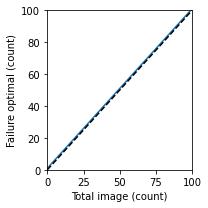

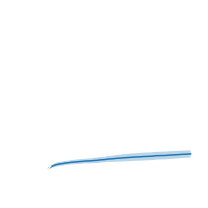

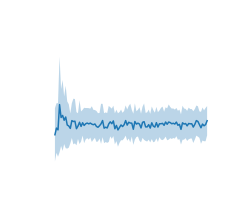

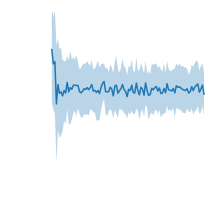

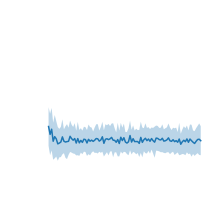

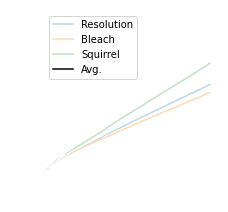

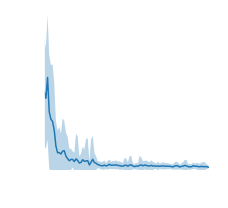

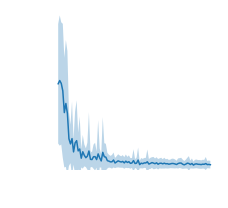

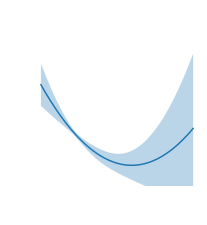

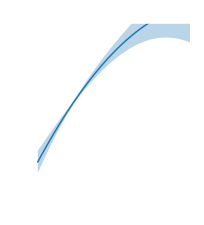

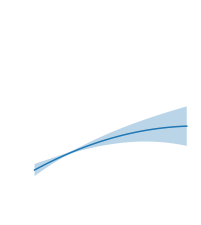

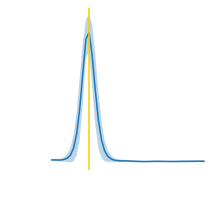

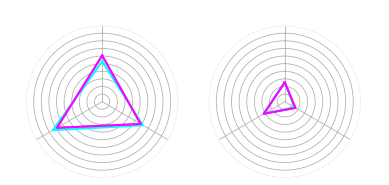

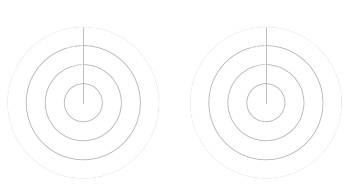

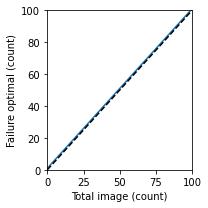

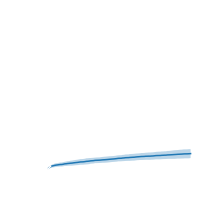

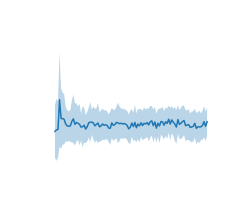

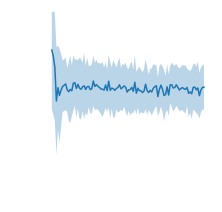

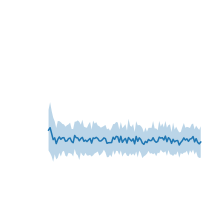

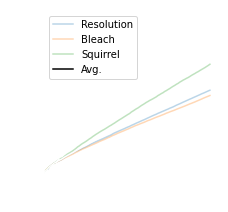

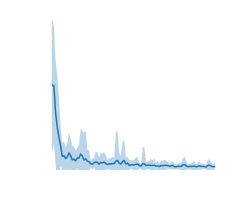

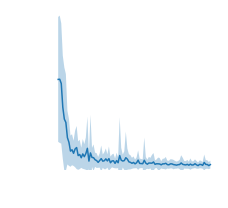

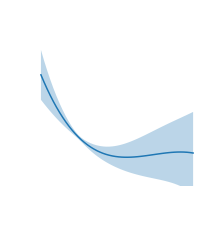

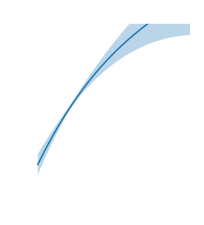

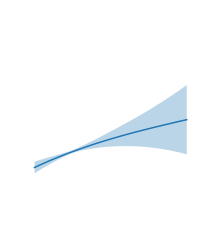

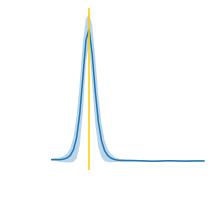

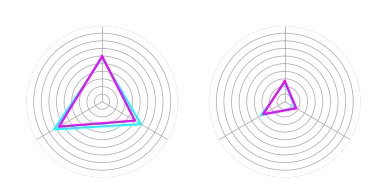

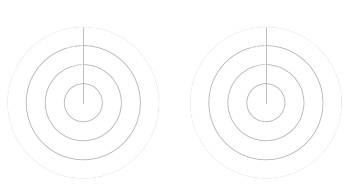

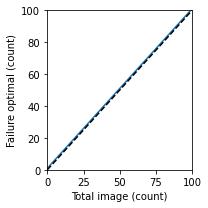

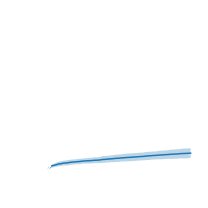

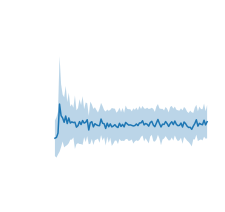

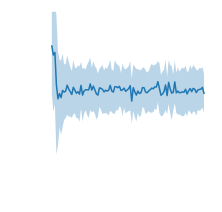

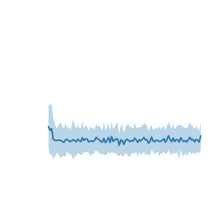

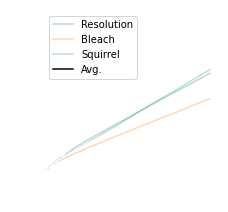

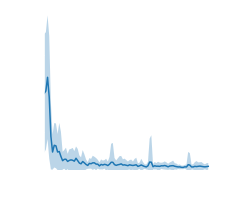

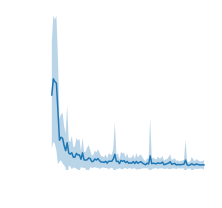

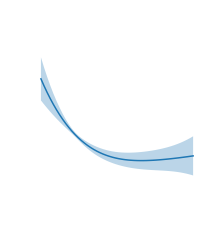

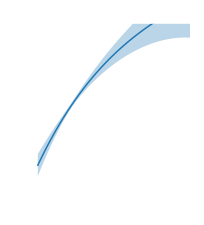

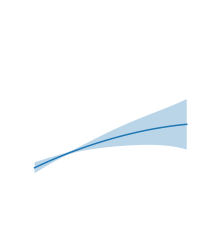

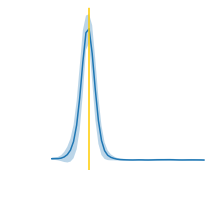

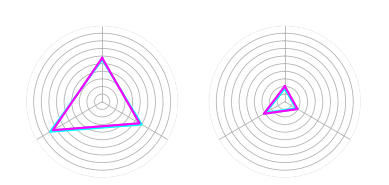

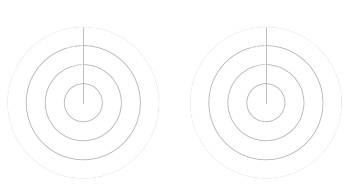

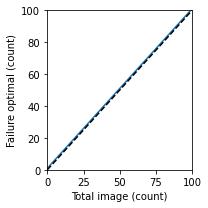

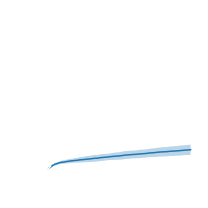

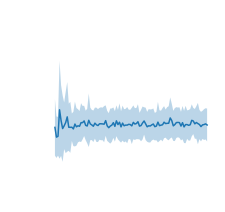

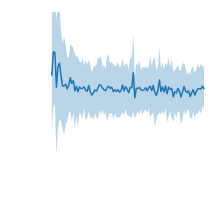

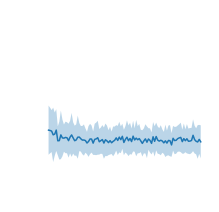

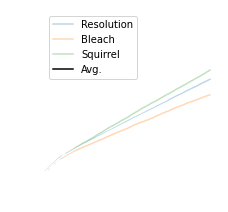

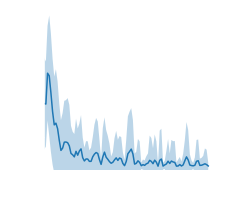

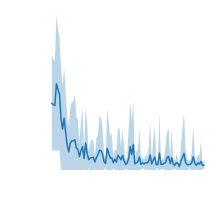

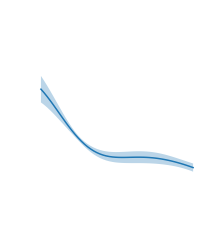

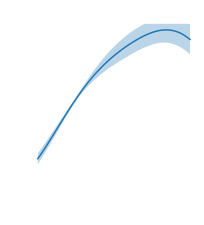

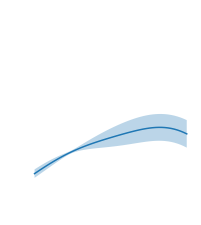

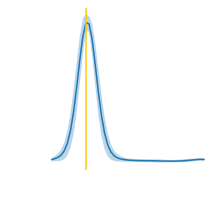

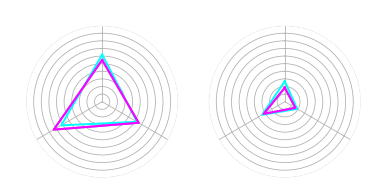

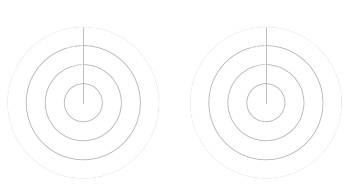

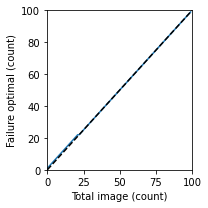

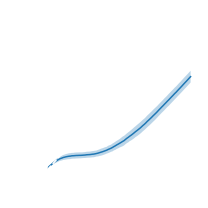

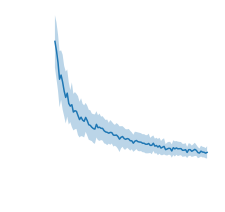

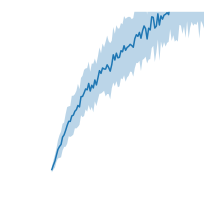

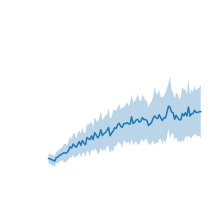

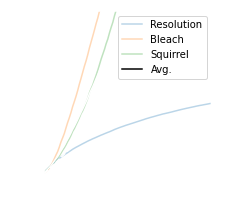

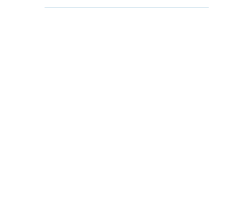

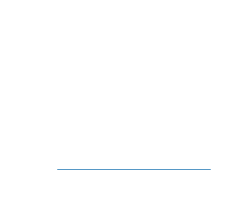

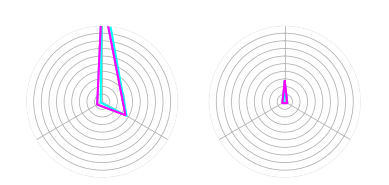

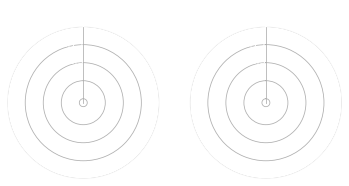

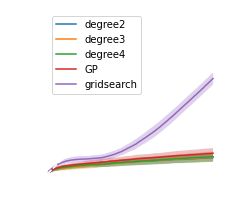

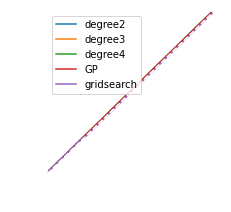

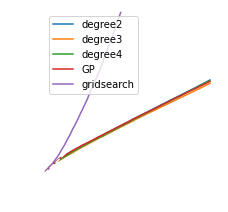

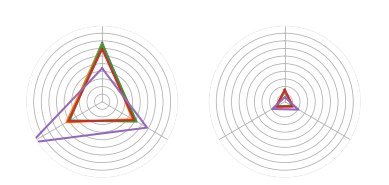

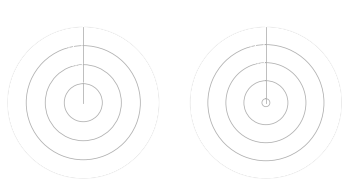

In [278]:
SAVE = True
param_name = "p_sted"

# Single parameter
os.makedirs("./panels/1parameters", exist_ok=True)

for model_name in model_names:
    
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))

    grids = numpy.meshgrid(*[
        numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)]) 
        for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
    ])
    x_grid = numpy.hstack([grid.ravel()[:,numpy.newaxis] for grid in grids])

    figaxes = plot_mean_optimal_parameter(stats[model_name])
    pyplot.show()
    
    figaxes = plot_mean_failures(stats[model_name])
    if SAVE:
        for key, (fig,ax) in figaxes.items():
            fig.savefig(os.path.join(PATH, model_name, "panels", f"failures_{key}.pdf"), bbox_inches="tight", transparent=True)
            change_figax_color(fig, ax)
            fig.savefig(os.path.join(PATH, model_name, "panels", f"failures_{key}_white.pdf"), bbox_inches="tight", transparent=True)
    pyplot.show()
    
    figaxes = plot_mean_sequences(stats[model_name])
    if SAVE:
        for key, (fig,ax) in figaxes.items():
            fig.savefig(os.path.join(PATH, model_name, "panels", f"sequences_{key}.pdf"), bbox_inches="tight", transparent=True)    
            change_figax_color(fig, ax)
            fig.savefig(os.path.join(PATH, model_name, "panels", f"sequences_{key}_white.pdf"), bbox_inches="tight", transparent=True)    
    pyplot.show()
    
    fig, ax = plot_mean_cumulative_std(stats[model_name])
    if SAVE:
        savefig(fig, ax, os.path.join(PATH, model_name, "panels", "cumulative_std"), save_white=True)
    pyplot.show()
    
    figaxes = plot_mean_param_sequences_dist(stats[model_name])
    if SAVE:
        for key, (fig, ax) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"param_sequences_dist_{key}"), save_white=True)
    pyplot.show()

    for obj_name, values in stats[model_name]["regressions"].items():

        values = numpy.array(values)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)
        
        fig, ax = pyplot.subplots(figsize=(3,3))
        ax.plot(x_grid[:, 0], mean)
        ax.fill_between(x_grid[:, 0], mean - std, mean + std, alpha=0.3)

        ax.set(
            title=obj_name, xlabel=param_name, 
            ylim=(OBJ_PLOT_LIM[obj_name]["min"], OBJ_PLOT_LIM[obj_name]["max"])
        )    

        if SAVE:
            fig.savefig(os.path.join(PATH, model_name, "panels", f"regressions_{obj_name}.pdf"), bbox_inches="tight", transparent=True)    
            change_figax_color(fig, ax)
            fig.savefig(os.path.join(PATH, model_name, "panels", f"regressions_{obj_name}_white.pdf"), bbox_inches="tight", transparent=True)    
        pyplot.show()
    
    for key, values in stats[model_name]["densities"].items():

        values = numpy.array(values)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)

        peaks = find_peaks_nd(mean)
        
        fig, ax = pyplot.subplots(figsize=(3,3))
        ax.plot(x_grid[:, 0], mean)
        ax.fill_between(x_grid[:, 0], mean - std, mean + std, alpha=0.3)
        ax.axvline(x=x_grid[peaks, 0], color="#ffcc00")
        ax.set(
            xlabel=param_name, 
            ylabel="Kernel density",
        )
        if SAVE:
            fig.savefig(os.path.join(PATH, model_name, "panels", f"densities_{obj_name}.pdf"), bbox_inches="tight", transparent=True)    
            change_figax_color(fig, ax)
            fig.savefig(os.path.join(PATH, model_name, "panels", f"densities_{obj_name}_white.pdf"), bbox_inches="tight", transparent=True)    
    pyplot.show()
    
    figaxes = plot_mean_radar_chart(stats[model_name])
    if SAVE:
        for key, (fig, axes) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"radar_{key}"), save_white=True)
    pyplot.show()
    
# Merge necessary figures 
fig, ax = pyplot.subplots(figsize=(3,3))
for model_name in model_names:
    _ = plot_mean_failures(stats[model_name], figax=(fig, ax))
cmap = pyplot.cm.get_cmap("tab10")
ax.legend(
    handles=[lines.Line2D([], [], color=cmap(i)) for i, (model_name) in enumerate(model_names)],
    labels=[model_name.split("_")[-1] for model_name in model_names],
    loc="upper left"
)
if SAVE:
    fig.savefig(
        os.path.join("./panels/1parameters", f"failures_{MICROSCOPE}_{N_TRIALS}.pdf"),
        transparent=True, bbox_inches="tight"
    )
    change_figax_color(fig, ax)
    fig.savefig(
        os.path.join("./panels/1parameters", f"failures_{MICROSCOPE}_{N_TRIALS}_white.pdf"),
        transparent=True, bbox_inches="tight"
    )
pyplot.show()

fig, ax = pyplot.subplots(figsize=(3,3))
for model_name in model_names:
    _ = plot_mean_optimal_parameter(stats[model_name], figax=(fig, ax))
cmap = pyplot.cm.get_cmap("tab10")
ax.legend(
    handles=[lines.Line2D([], [], color=cmap(i)) for i, (model_name) in enumerate(model_names)],
    labels=[model_name.split("_")[-1] for model_name in model_names],
    loc="upper left"
)
if SAVE:
    fig.savefig(
        os.path.join("./panels/1parameters", f"failures-optimal_{MICROSCOPE}_{N_TRIALS}.pdf"),
        transparent=True, bbox_inches="tight"
    )
    change_figax_color(fig, ax)
    fig.savefig(
        os.path.join("./panels/1parameters", f"failures-optimal_{MICROSCOPE}_{N_TRIALS}.pdf"),
        transparent=True, bbox_inches="tight"
    )
pyplot.show()

fig, ax = plot_cumulative_std(stats)
if SAVE:
    savefig(fig, ax, os.path.join("./panels/1parameters", f"cumulative-std_{MICROSCOPE}_{N_TRIALS}"), save_white=True)
    
figaxes = plot_radar_chart(stats)
if SAVE:
    for key, (fig, axes) in figaxes.items():
        savefig(fig, ax, os.path.join("./panels/1parameters", f"radar_{key}_{MICROSCOPE}_{N_TRIALS}"), save_white=True)

<a id="2parameters"></a>
# Analysis of 2D models

In [286]:
SAVE = True
SHOW = False
MICROSCOPE = "DyMIN"
model_names_microscope = {
    "DyMIN" : [
#         "20210623-105256_DyMIN_prefnet_2params_3objectives_degree4",
#         "20210630-061632_DyMIN_prefnet_2params_3objectives_degree3",
#         "20210630-160821_DyMIN_prefnet_2params_3objectives_degree2",
#         "20210709-100051_DyMIN_prefnet_2params_3objectives_degree2", # no pareto
#         "20210709-095504_DyMIN_prefnet_2params_3objectives_degree3", # no pareto
#         "20210709-095607_DyMIN_prefnet_2params_3objectives_degree4", # no pareto
        "20210716-132034_DyMIN_prefnet_2params_3objectives_degree2",
        "20210716-132034_DyMIN_prefnet_2params_3objectives_degree3",
        "20210716-132034_DyMIN_prefnet_2params_3objectives_degree4",
        "20210728-115816_DyMIN_prefnet_2params_3objectives_GP",
        "20210729-140738_DyMIN_random_2params_3objectives_gridsearch"
    ],
    "RESCue" : [
#         "20210623-133229_RESCue_prefnet_2params_3objectives_degree4",
#         "20210630-061632_RESCue_prefnet_2params_3objectives_degree3",
#         "20210630-160824_RESCue_prefnet_2params_3objectives_degree2",  
#         "20210709-095504_RESCue_prefnet_2params_3objectives_degree2", # no pareto
#         "20210709-095612_RESCue_prefnet_2params_3objectives_degree3", # no pareto
#         "20210709-095705_RESCue_prefnet_2params_3objectives_degree4", # no pareto 
        "20210716-132046_RESCue_prefnet_2params_3objectives_degree2",
        "20210716-132046_RESCue_prefnet_2params_3objectives_degree3",
        "20210716-132046_RESCue_prefnet_2params_3objectives_degree4",  
        "20210728-115819_RESCue_prefnet_2params_3objectives_GP",
        "20210729-140818_RESCue_random_2params_3objectives_gridsearch"
    ]
}
model_names = model_names_microscope[MICROSCOPE]

OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 40.,
        "max" : 180.,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 0.5,
    },
    "Squirrel" : {
        "min" : 5.,
        "max" : 25.,
    }
}

stats = {model_name : {key : defaultdict(list) for key in ["failures", "regressions", "densities", "sequences", "param_sequences"]} for model_name in model_names}
for model_name in model_names:
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))
    is_gridsearch = "gridsearch" in model_name
    for trial in trange(N_TRIALS, leave=False, desc=model_name):
        X, y = load_data(os.path.join(PATH, model_name), trial=trial, gridsearch=is_gridsearch)
        if (len(X[PARAM_NAMES[0]]) != CONFIG["optim_length"]) and (not is_gridsearch):
            print(f"aborting at trial : {trial}")
            break        

        # Creation of savepath
        savepath = os.path.join(PATH, model_name, "panels", str(trial))
        os.makedirs(savepath, exist_ok=True)

        # Plots the regression model
        if not is_gridsearch:
            figaxes, mean_regressions, density = plot_data_2d(X, y)
            for key, values in mean_regressions.items():
                stats[model_name]["regressions"][key].append(values)
            stats[model_name]["densities"]["densities"].append(density)        
            if SAVE and (trial == 0):
                for obj_name, (fig, ax) in figaxes.items():
                    fig.savefig(os.path.join(savepath, f"regression_{obj_name}.pdf"), transparent=True, bbox_inches="tight")
            if SHOW:
                pyplot.show()
            else:
                pyplot.close("all")

        # Plots the sequence of choices
        fig, axes = plot_sequence(X, y)
        for obj_name, values in y.items():
            stats[model_name]["sequences"][obj_name].append(values)
        if SAVE and (trial == 0):
            fig.savefig(os.path.join(savepath, "sequence.pdf"), transparent=True, bbox_inches="tight")        
        if SHOW:
            pyplot.show()
        else:
            pyplot.close("all")
            
        # Gets the parameter selection
        for pname in CONFIG["param_names"]:
            for i in range(NDIMS[CONFIG["param_names"].index(pname)]):
                stats[model_name]["param_sequences"][f"{pname}-{i}"].append(X[pname][:, i])            
        
        # Plots the number of failures
        fig, ax, failures = plot_failures(X, y)
        stats[model_name]["failures"]["failures"].append(failures)
        if SHOW:
            pyplot.show()
        else:
            pyplot.close("all")        

        for image_type in ["conf1", "sted", "conf2"]:
            if os.path.isfile(os.path.join(PATH, model_name, "optim.hdf5")):
                with h5py.File(os.path.join(PATH, model_name, "optim.hdf5")) as file:
                    image_path = file[image_type][f"{trial}"]
                    collage = show_montage(X, y, image_path, nrows=1, vmax=250)
                    out_collages = show_N_images(X, y, image_path, ncols=5, vmax=250, image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))
            else:
                image_path = os.path.join(PATH, model_name, image_type, f"{trial}")
                collage = show_montage(X, y, image_path, nrows=1, vmax=250)
                out_collages = show_N_images(X, y, image_path, ncols=5, vmax=250, image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))
            if SHOW:
                display(collage)
            if SAVE and (trial == 0):
                collage.save(os.path.join(savepath, f"montage_{image_type}.tif"))
                for key, col in out_collages.items():
                    col.save(os.path.join(savepath, f"{key}_{image_type}.tif"))

20210716-132034_DyMIN_prefnet_2params_3objectives_degree2:   0%|          | 0/50 [00:00<?, ?it/s]

20210716-132034_DyMIN_prefnet_2params_3objectives_degree3:   0%|          | 0/50 [00:00<?, ?it/s]

20210716-132034_DyMIN_prefnet_2params_3objectives_degree4:   0%|          | 0/50 [00:00<?, ?it/s]

20210728-115816_DyMIN_prefnet_2params_3objectives_GP:   0%|          | 0/50 [00:00<?, ?it/s]

20210729-140738_DyMIN_random_2params_3objectives_gridsearch:   0%|          | 0/50 [00:00<?, ?it/s]

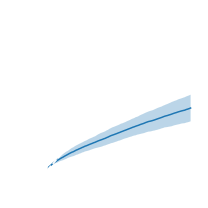

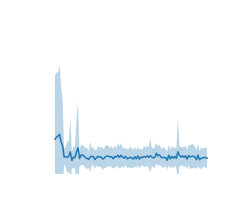

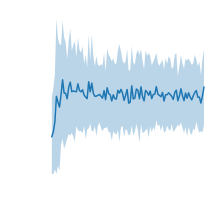

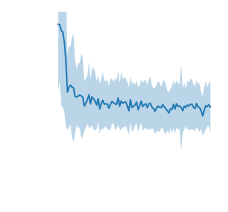

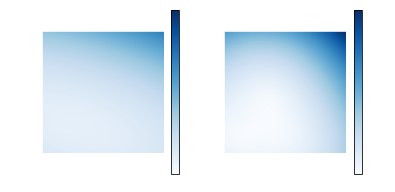

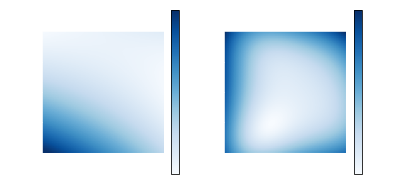

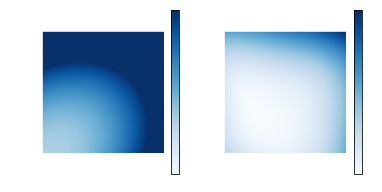

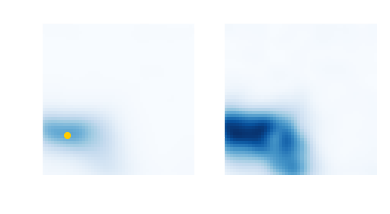

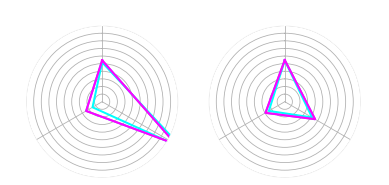

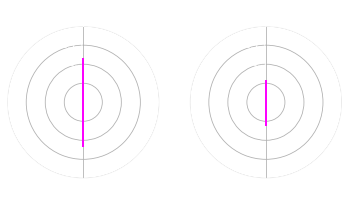

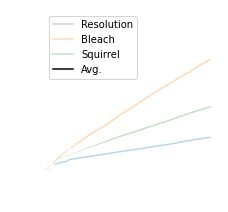

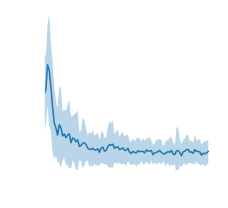

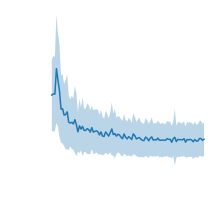

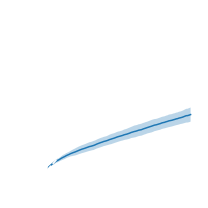

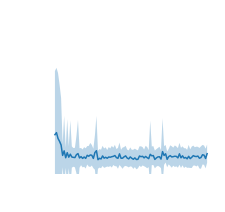

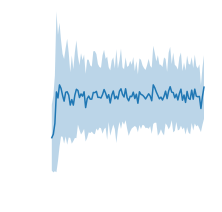

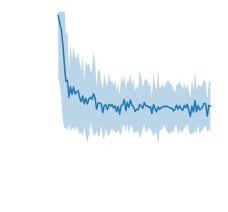

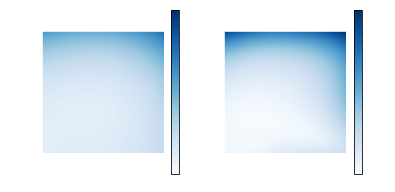

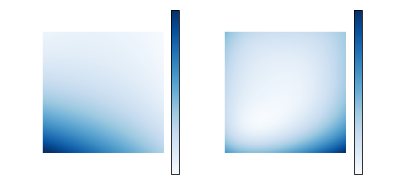

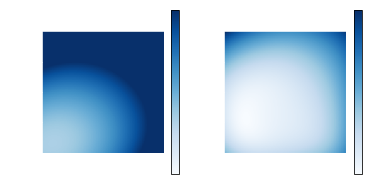

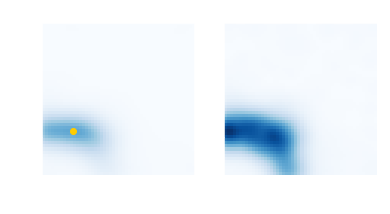

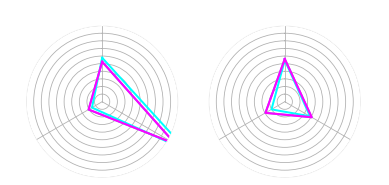

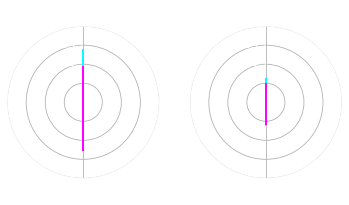

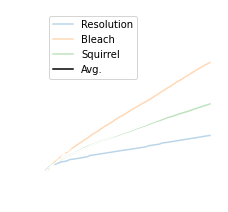

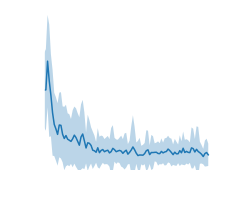

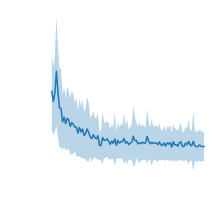

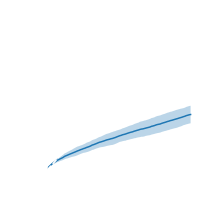

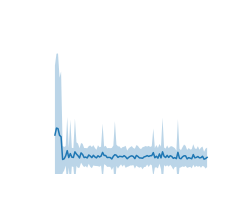

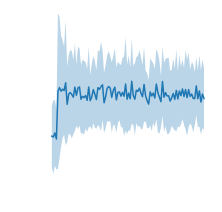

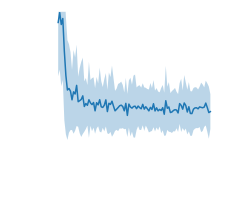

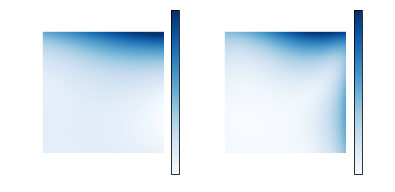

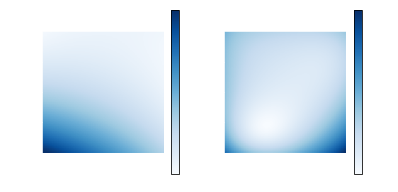

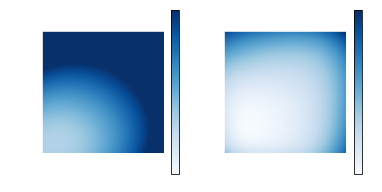

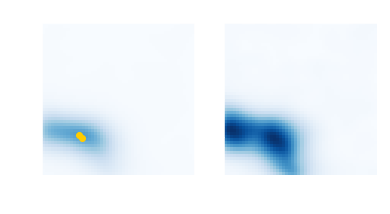

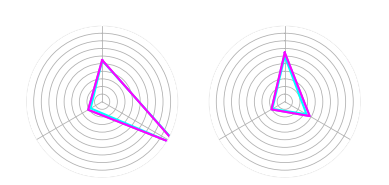

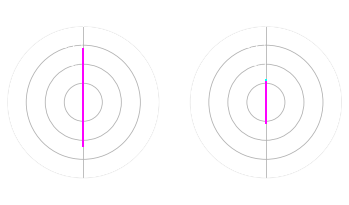

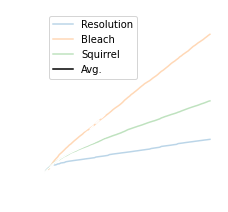

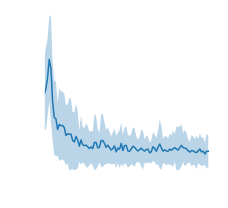

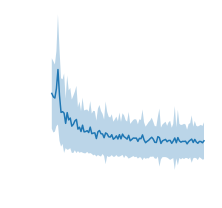

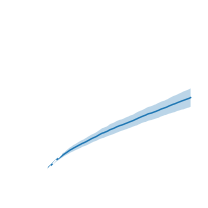

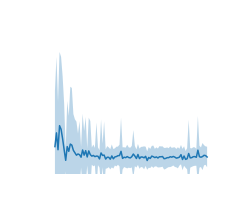

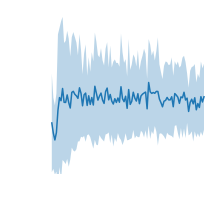

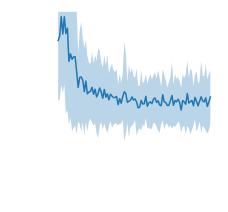

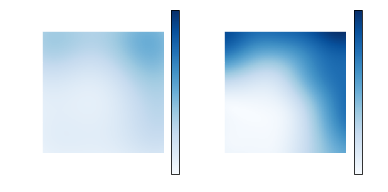

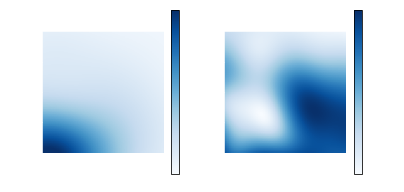

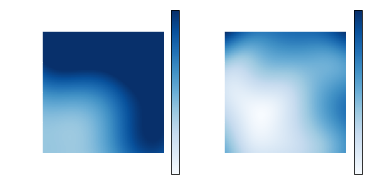

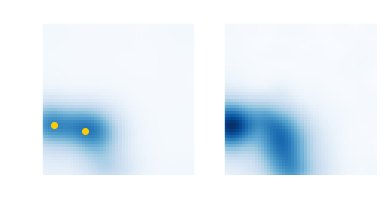

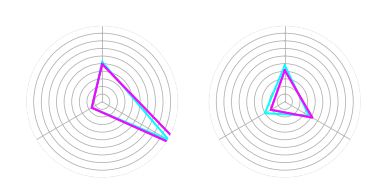

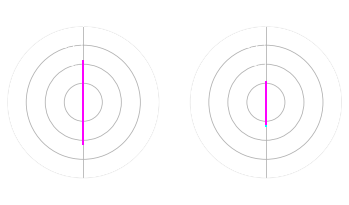

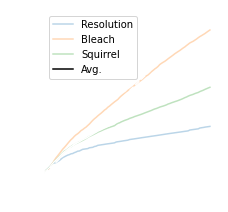

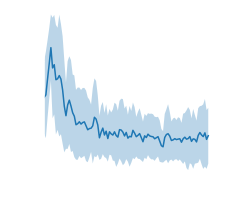

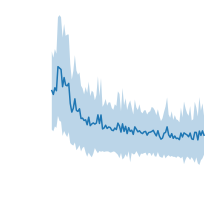

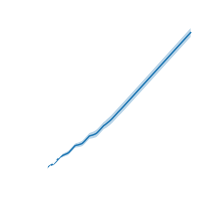

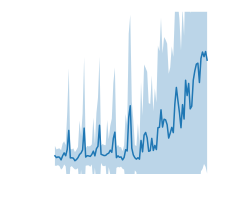

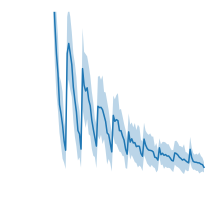

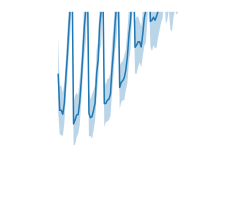

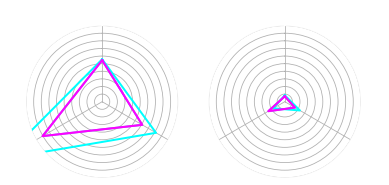

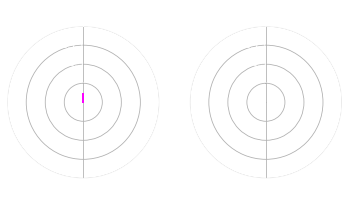

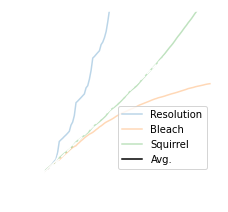

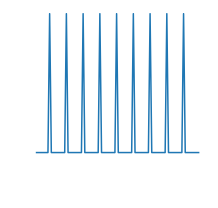

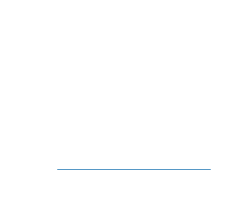

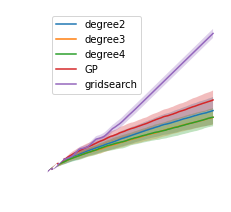

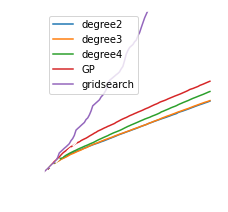

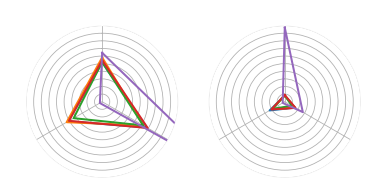

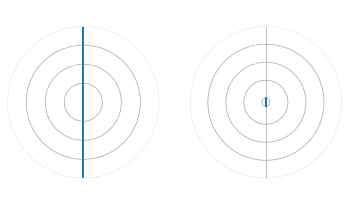

In [287]:
SAVE = True

# Single parameter
os.makedirs("./panels/2parameters", exist_ok=True)

for model_name in model_names:
    
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))
    
    # Creates the grid for future use
    grids = numpy.meshgrid(*[
        numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)]) 
        for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
    ])
    x_grid = numpy.hstack([grid.ravel()[:,numpy.newaxis] for grid in grids])    
    
    figaxes = plot_mean_failures(stats[model_name])
    if SAVE:
        for key, (fig,ax) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{key}"), save_white=True)
    pyplot.show()
    
    figaxes = plot_mean_sequences(stats[model_name])
    if SAVE:
        for key, (fig,ax) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"sequences_{key}"), save_white=True)
    pyplot.show()    
    
    # Plots mean regression
    for key, values in stats[model_name]["regressions"].items():

        values = numpy.array(values)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)
        mean, std = mean.reshape(grids[0].shape), std.reshape(grids[0].shape)
        
        fig, axes = pyplot.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True)
        im = axes[0].imshow(
            mean, origin="lower",
            extent=(
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[1])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[1])]
            ),
            cmap="Blues",
            vmin=OBJ_PLOT_LIM[key]["min"], 
            vmax=OBJ_PLOT_LIM[key]["max"]
        )
        fig.colorbar(im, ax=axes[0])
        im = axes[1].imshow(
            std, origin="lower",
            extent=(
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[1])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[1])]
            ),
            cmap="Blues"
        )
        fig.colorbar(im, ax=axes[1])
        for title, ax in zip([f"{key} - mean", f"{key} - std"], axes.ravel()):
            ax.set(
                title=title,
                xlabel=PARAM_NAMES[0], 
                ylabel=PARAM_NAMES[1]
            )
        if SAVE:
            savefig(fig, axes, os.path.join(PATH, model_name, "panels", f"regression_{key}"), save_white=True)
    pyplot.show()       
    
    # Plots densities
    for key, values in stats[model_name]["densities"].items():
        param_space = numpy.array([
            numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)]) 
            for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
        ])
        
        values = numpy.array(values)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)
        mean, std = mean.reshape(grids[0].shape), std.reshape(grids[0].shape)
        
        peaks = find_peaks_nd(mean)
        
        fig, axes = pyplot.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True)
        im = axes[0].imshow(
            mean, 
            origin="lower",
            extent=(
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[1])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[1])]
            ),
            cmap="Blues",
            vmin=0., vmax=1
        )

        yxcoords = numpy.stack([param_space[i, peaks[:, i]] for i in range(len(param_space))])
        axes[0].scatter(*yxcoords[::-1], color="#ffcc00")
        im = axes[1].imshow(
            std, origin="lower",
            extent=(
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[0])], 
                CONFIG["x_mins"][CONFIG["param_names"].index(PARAM_NAMES[1])], 
                CONFIG["x_maxs"][CONFIG["param_names"].index(PARAM_NAMES[1])]
            ),
            cmap="Blues"
        )
        for title, ax in zip(["kde - mean", "kde - std"], axes.ravel()):
            ax.set(
                title=title,
                xlabel=PARAM_NAMES[0], 
                ylabel=PARAM_NAMES[1]
            )
    if SAVE:
        savefig(fig, axes, os.path.join(PATH, model_name, "panels", f"densities_{key}"), save_white=True)
    pyplot.show()    
    
    figaxes = plot_mean_radar_chart(stats[model_name])
    if SAVE:
        for key, (fig, axes) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"radar_{key}"), save_white=True)
    pyplot.show()  
    
    fig, ax = plot_mean_cumulative_std(stats[model_name])
    if SAVE:
        savefig(fig, ax, os.path.join(PATH, model_name, "panels", "cumulative_std"), save_white=True)

    figaxes = plot_mean_param_sequences_dist(stats[model_name])
    if SAVE:
        for key, (fig, axes) in figaxes.items():
            savefig(fig, axes, os.path.join(PATH, model_name, "panels", f"param_sequences_dist_{key}"), save_white=True)
    pyplot.show()        
        
# Merge necessary figures 
fig, ax = pyplot.subplots(figsize=(3,3))
for model_name in model_names:
    _ = plot_mean_failures(stats[model_name], figax=(fig, ax))
cmap = pyplot.cm.get_cmap("tab10")
ax.legend(
    handles=[lines.Line2D([], [], color=cmap(i)) for i, (model_name) in enumerate(model_names)],
    labels=[model_name.split("_")[-1] for model_name in model_names],
    loc="upper left"
)
if SAVE:
    savefig(fig, ax, os.path.join("./panels/2parameters", f"failures_{MICROSCOPE}_{N_TRIALS}"), save_white=True)
pyplot.show()

fig, ax = plot_cumulative_std(stats)
if SAVE:
    savefig(fig, ax, os.path.join("./panels/2parameters", f"cumulative-std_{MICROSCOPE}_{N_TRIALS}"), save_white=True)

figaxes = plot_radar_chart(stats)
if SAVE:
    for key, (fig, axes) in figaxes.items():
        savefig(fig, axes, os.path.join("./panels/2parameters", f"radar_{key}_{MICROSCOPE}_{N_TRIALS}"), save_white=True)
    
# fig, ax = pyplot.subplots(figsize=(3,3))
# for model_name in model_names:
#     _ = plot_mean_optimal_parameter(stats[model_name], figax=(fig, ax))
# cmap = pyplot.cm.get_cmap("tab10")
# ax.legend(
#     handles=[lines.Line2D([], [], color=cmap(i)) for i, (model_name) in enumerate(model_names)],
#     labels=[model_name.split("_")[-1] for model_name in model_names],
#     loc="upper left"
# )
# if SAVE:
#     fig.savefig(
#         os.path.join("./panels/2parameters", f"failures-optimal_{MICROSCOPE}_{N_TRIALS}.pdf"),
#         transparent=True, bbox_inches="tight"
#     )
# pyplot.show()

<a id="3parameters"></a>
# Analysis of 3D models

In [292]:
SAVE = True
SHOW = False
MICROSCOPE = "RESCue"
model_names_microscope = {
    "DyMIN" : [
#         "20210623-105256_DyMIN_prefnet_3params_3objectives_degree4",
#         "20210630-061632_DyMIN_prefnet_3params_3objectives_degree3",
#         "20210630-160821_DyMIN_prefnet_3params_3objectives_degree2",
#         "20210709-100051_DyMIN_prefnet_3params_3objectives_degree2", # no pareto
#         "20210709-095504_DyMIN_prefnet_3params_3objectives_degree3", # no pareto
#         "20210709-095658_DyMIN_prefnet_3params_3objectives_degree4", # no pareto
        "20210716-132034_DyMIN_prefnet_3params_3objectives_degree2",
        "20210719-084155_DyMIN_prefnet_3params_3objectives_degree3",
        "20210716-132034_DyMIN_prefnet_3params_3objectives_degree4",  
        "20210728-115816_DyMIN_prefnet_3params_3objectives_GP",
        "20210729-140738_DyMIN_random_3params_3objectives_gridsearch"
    ],
    "RESCue" : [
#         "20210623-133229_RESCue_prefnet_3params_3objectives_degree4",
#         "20210630-061632_RESCue_prefnet_3params_3objectives_degree3",
#         "20210630-160824_RESCue_prefnet_3params_3objectives_degree2",
#         "20210709-095504_RESCue_prefnet_3params_3objectives_degree2", # no pareto
#         "20210709-095612_RESCue_prefnet_3params_3objectives_degree3", # no pareto
#         "20210709-095705_RESCue_prefnet_3params_3objectives_degree4", # no pareto 
        "20210716-132045_RESCue_prefnet_3params_3objectives_degree2",
        "20210716-132046_RESCue_prefnet_3params_3objectives_degree3",
        "20210716-132046_RESCue_prefnet_3params_3objectives_degree4", 
        "20210728-115820_RESCue_prefnet_3params_3objectives_GP",
        "20210729-140818_RESCue_random_3params_3objectives_gridsearch"
    ], 
    "Human" : [
        "20210622-075840_optim_3params_3objectives_degree4"
    ]
}
model_names = model_names_microscope[MICROSCOPE]

OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 40.,
        "max" : 180.,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 0.5,
    },
    "Squirrel" : {
        "min" : 5.,
        "max" : 30.,
    }
}

stats = {model_name : {key : defaultdict(list) for key in ["failures", "regressions", "densities", "sequences", "param_sequences"]} for model_name in model_names}
for model_name in model_names:
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))
    is_gridsearch = "gridsearch" in model_name
    for trial in trange(N_TRIALS, desc=model_name, leave=False):
        X, y = load_data(os.path.join(PATH, model_name), trial=trial, gridsearch=is_gridsearch)
        if (len(X[PARAM_NAMES[0]]) != CONFIG["optim_length"]) and (not is_gridsearch):
            print(f"aborting at trial : {trial}")
            break

        # Creation of savepath
        savepath = os.path.join(PATH, model_name, "panels", str(trial))
        os.makedirs(savepath, exist_ok=True)

        # Plots the regression model
        if not is_gridsearch:
            figaxes, unique_values, density = plot_data_3d(X, y, "p_sted")
            stats[model_name]["densities"]["densities"].append(density)
            if SAVE and trial==0:
                for obj_name, (fig, ax) in figaxes.items():
                    savefig(fig, ax, os.path.join(savepath, f"regression_{obj_name}"), save_white=True)
            if SHOW:
                pyplot.show()
            else:
                pyplot.close("all")

        # Plots the sequence of choices
        fig, axes = plot_sequence(X, y)
        for obj_name, values in y.items():
            stats[model_name]["sequences"][obj_name].append(values)
        if SAVE and trial==0:
            savefig(fig, ax, os.path.join(savepath, "sequence"), save_white=True)
        if SHOW:
            pyplot.show()
        else:
            pyplot.close("all")
            
        # Gets the parameter selection
        for pname in CONFIG["param_names"]:
            for i in range(NDIMS[CONFIG["param_names"].index(pname)]):
                stats[model_name]["param_sequences"][f"{pname}-{i}"].append(X[pname][:, i])                      

        # Plots the number of failures
        fig, ax, failures = plot_failures(X, y)
        stats[model_name]["failures"]["failures"].append(failures)
        if SHOW:
            pyplot.show()
        else:
            pyplot.close("all")              

        for image_type in ["conf1", "sted", "conf2"]:   
            if os.path.isfile(os.path.join(PATH, model_name, "optim.hdf5")):
                with h5py.File(os.path.join(PATH, model_name, "optim.hdf5")) as file:
                    image_path = file[image_type][f"{trial}"]
                    for unique_value in unique_values:
                        _X, _y, image_indices = filterdict(X, y, "p_sted", unique_value)
                        collage = show_montage(_X, _y, image_path, vmax=250, 
                                               image_indices=image_indices,
                                              rm_param=["p_sted"])
                        if SHOW:
                            display(collage)
                        if SAVE and trial==0:
                            collage.save(os.path.join(savepath, f"montage_{image_type}_psted{unique_value * 1e+3:0.4f}.tif"))                        
                    out_collages = show_N_images(X, y, image_path, ncols=5, vmax=250, image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))
                    if SAVE and trial == 0:
                        for key, col in out_collages.items():
                            col.save(os.path.join(savepath, f"{key}_{image_type}.tif"))
            else:
                image_path = os.path.join(PATH, model_name, image_type, f"{trial}")
                for unique_value in unique_values:
                    _X, _y, image_indices = filterdict(X, y, "p_sted", unique_value)
                    collage = show_montage(_X, _y, image_path, vmax=250, 
                                           image_indices=image_indices,
                                          rm_param=["p_sted"])
                    if SHOW:
                        display(collage)
                    if SAVE and trial==0:
                        collage.save(os.path.join(savepath, f"montage_{image_type}_psted{unique_value * 1e+3:0.4f}.tif"))                
                out_collages = show_N_images(X, y, image_path, ncols=5, vmax=250, image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))            
                if SAVE and trial == 0:
                    for key, col in out_collages.items():
                        col.save(os.path.join(savepath, f"{key}_{image_type}.tif"))            

20210716-132045_RESCue_prefnet_3params_3objectives_degree2:   0%|          | 0/50 [00:00<?, ?it/s]

20210716-132046_RESCue_prefnet_3params_3objectives_degree3:   0%|          | 0/50 [00:00<?, ?it/s]

20210716-132046_RESCue_prefnet_3params_3objectives_degree4:   0%|          | 0/50 [00:00<?, ?it/s]

20210728-115820_RESCue_prefnet_3params_3objectives_GP:   0%|          | 0/50 [00:00<?, ?it/s]

20210729-140818_RESCue_random_3params_3objectives_gridsearch:   0%|          | 0/50 [00:00<?, ?it/s]

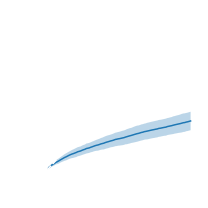

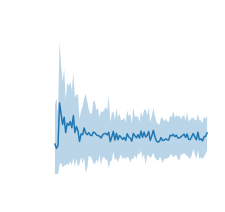

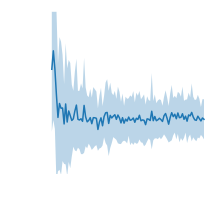

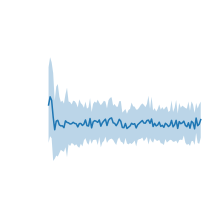

['p_sted', 'lower_threshold', 'upper_threshold']
[[2.55224490e-03 4.48979592e+00 8.16326531e+00]]


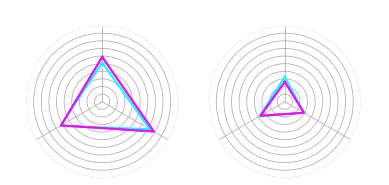

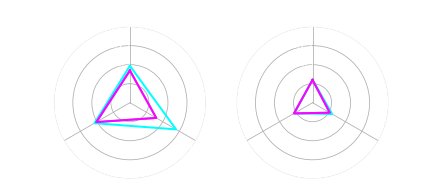

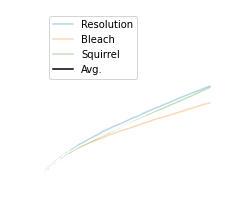

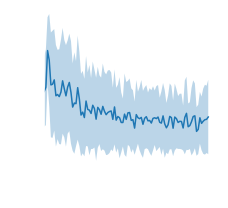

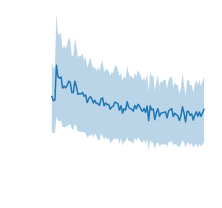

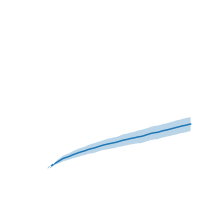

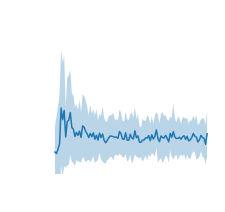

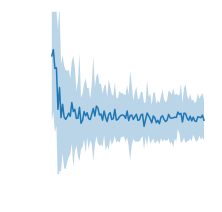

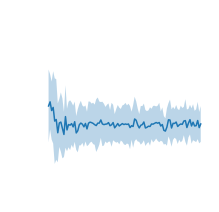

['p_sted', 'lower_threshold', 'upper_threshold']
[[2.55224490e-03 4.48979592e+00 7.75510204e+00]]


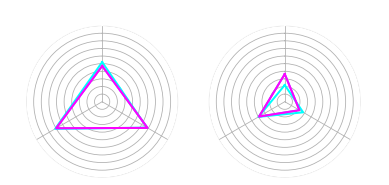

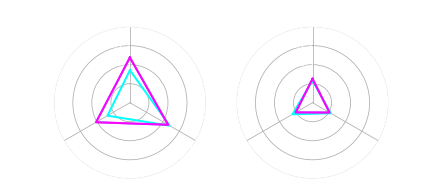

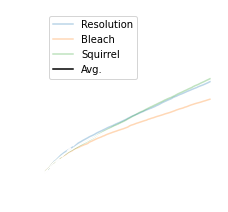

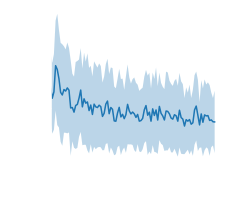

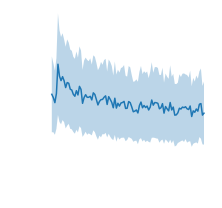

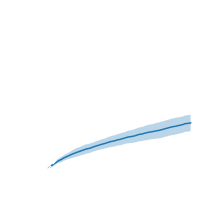

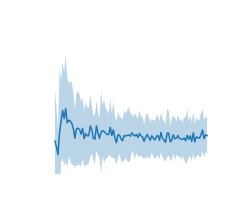

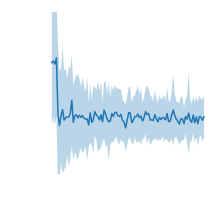

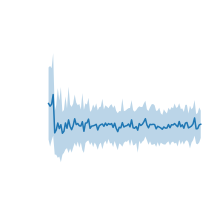

['p_sted', 'lower_threshold', 'upper_threshold']
[[2.55224490e-03 4.48979592e+00 6.12244898e+00]]


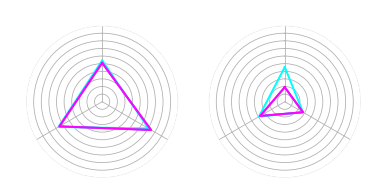

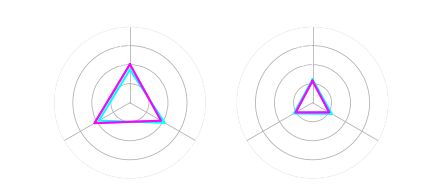

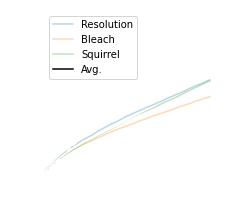

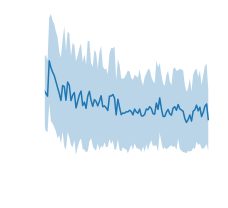

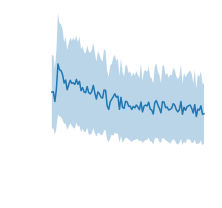

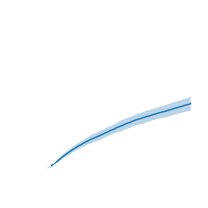

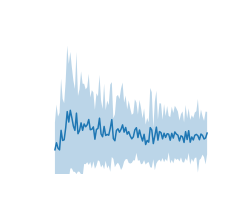

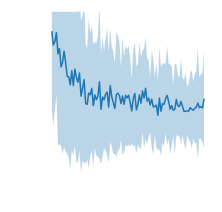

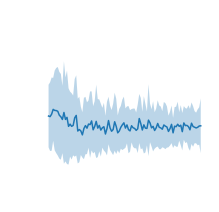

['p_sted', 'lower_threshold', 'upper_threshold']
[[2.14428571e-03 5.30612245e+00 1.06122449e+01]
 [2.34826531e-03 4.89795918e+00 1.14285714e+01]
 [2.24627551e-03 4.89795918e+00 1.10204082e+01]]


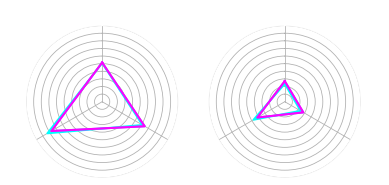

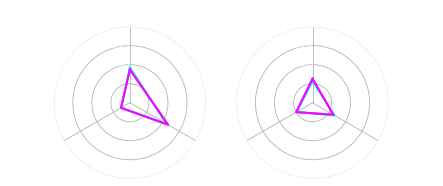

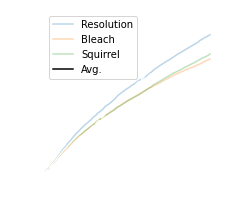

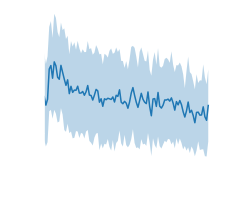

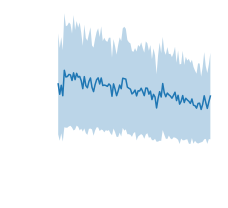

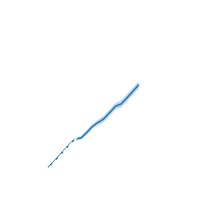

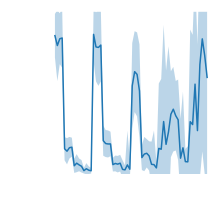

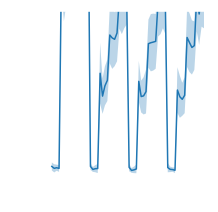

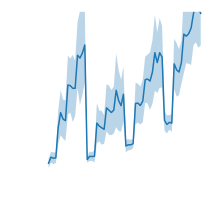

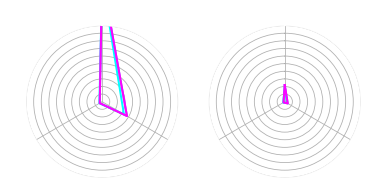

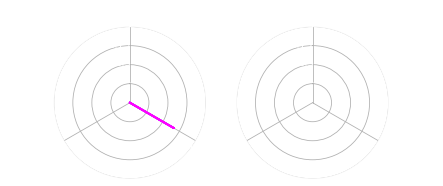

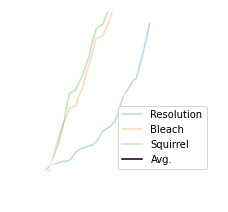

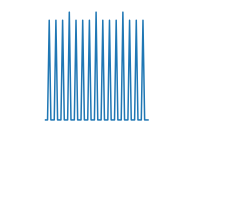

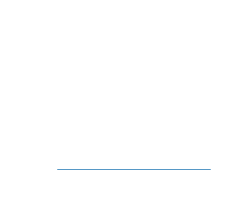

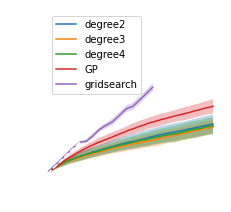

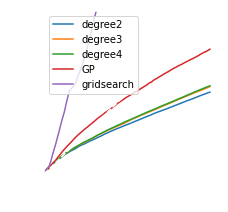

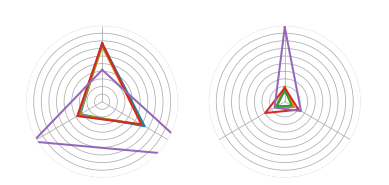

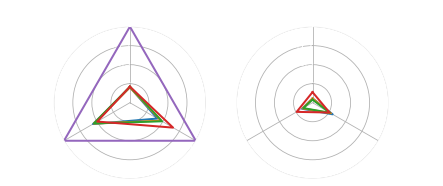

In [293]:
SAVE = True

# Single parameter
os.makedirs("./panels/3parameters", exist_ok=True)

for model_name in model_names:
    
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))
    
    # Creates the grid for future use
    grids = numpy.meshgrid(*[
        numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)]) 
        for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
    ])
    x_grid = numpy.hstack([grid.ravel()[:,numpy.newaxis] for grid in grids])      
    
    figaxes = plot_mean_failures(stats[model_name])
    if SAVE:
        for key, (fig,ax) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{key}"), save_white=True)
    pyplot.show()
    
    figaxes = plot_mean_sequences(stats[model_name])
    if SAVE:
        for key, (fig,ax) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{key}"), save_white=True)
    pyplot.show()    
    
    # Plots densities
    for key, values in stats[model_name]["densities"].items():
        param_space = numpy.array([
            numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)]) 
            for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
        ])
        
        values = numpy.array(values)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)
        mean, std = mean.reshape(grids[0].shape), std.reshape(grids[0].shape)
        
        peaks = find_peaks_nd(mean)
        coords = numpy.stack([param_space[i, peaks[:, i]] for i in range(len(param_space))])
        print(CONFIG["param_names"])
        print(coords.T)
    pyplot.show()
    
    # Plots radar charts
    figaxes = plot_mean_radar_chart(stats[model_name])
    if SAVE:
        for key, (fig, axes) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"radar_{key}"), save_white=True)
    pyplot.show()    
    
    fig, ax = plot_mean_cumulative_std(stats[model_name])
    if SAVE:
        savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"cumulative-std"), save_white=True)    
    pyplot.show()

    figaxes = plot_mean_param_sequences_dist(stats[model_name])
    if SAVE:
        for key, (fig, axes) in figaxes.items():
            savefig(fig, axes, os.path.join(PATH, model_name, "panels", f"param_sequences_dist_{key}"), save_white=True)
    pyplot.show()


# Merge necessary figures 
fig, ax = pyplot.subplots(figsize=(3,3))
for model_name in model_names:
    _ = plot_mean_failures(stats[model_name], figax=(fig, ax))
cmap = pyplot.cm.get_cmap("tab10")
ax.legend(
    handles=[lines.Line2D([], [], color=cmap(i)) for i, (model_name) in enumerate(model_names)],
    labels=[model_name.split("_")[-1] for model_name in model_names],
    loc="upper left"
)
if SAVE:
    savefig(fig, ax, os.path.join("./panels/3parameters", f"failures_{MICROSCOPE}_{N_TRIALS}"), save_white=True)
pyplot.show()    

fig, ax = plot_cumulative_std(stats)
if SAVE:
    savefig(fig, ax, os.path.join("./panels/3parameters", f"cumulative-std_{MICROSCOPE}_{N_TRIALS}"), save_white=True)    
    
figaxes = plot_radar_chart(stats)
if SAVE:
    for key, (fig, axes) in figaxes.items():
        savefig(fig, axes, os.path.join("./panels/3parameters", f"radar_{key}_{MICROSCOPE}_{N_TRIALS}"), save_white=True)

<a id="Nparameters"></a>
# Analysis of >3D models

20211025_M-Tubulin_GAM-STAR635/20211026-135819_AbberiorDyMIN_optim_14params_3objectives_degree3:   0%|        …

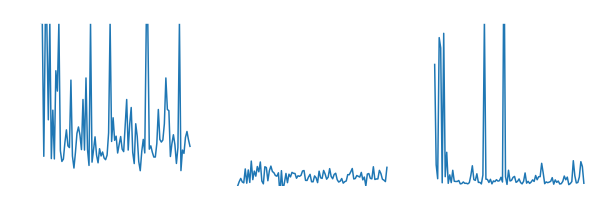

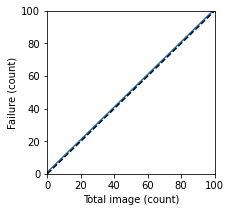

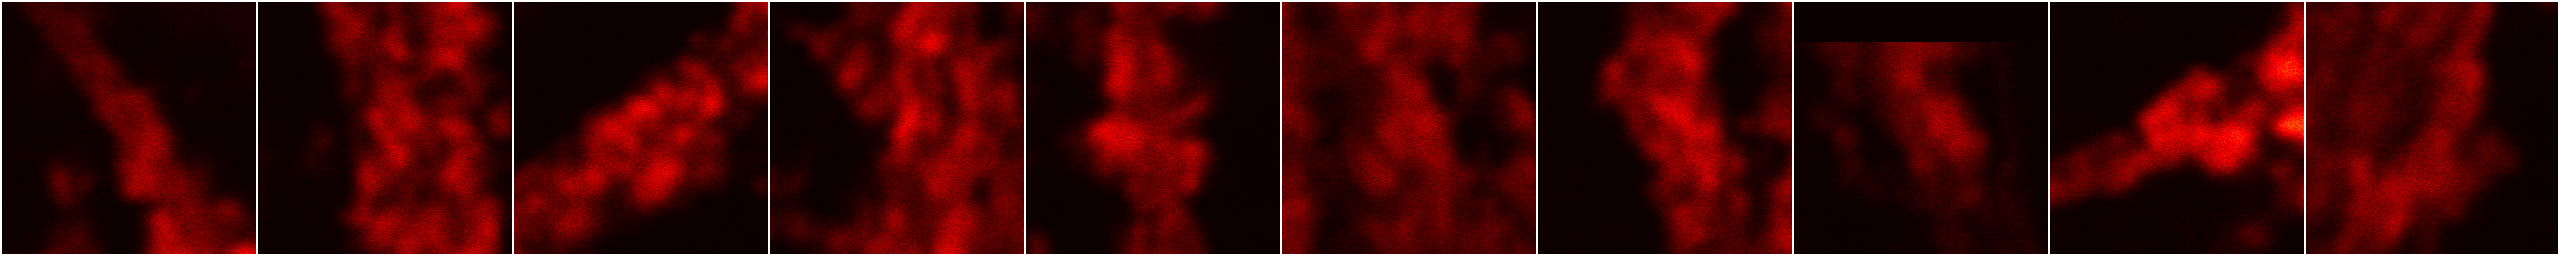

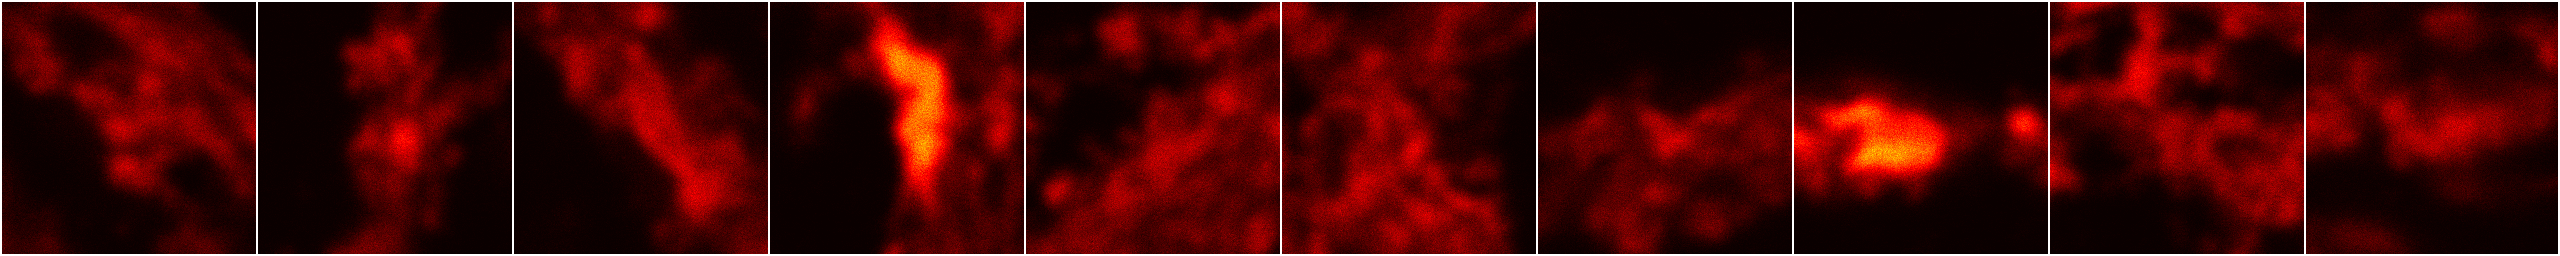

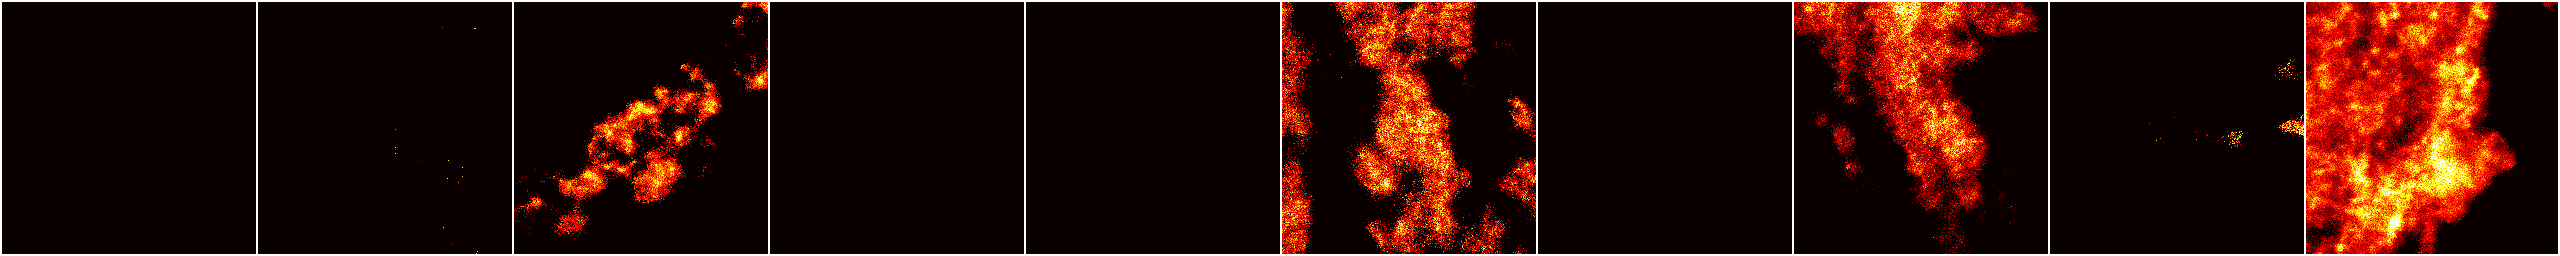

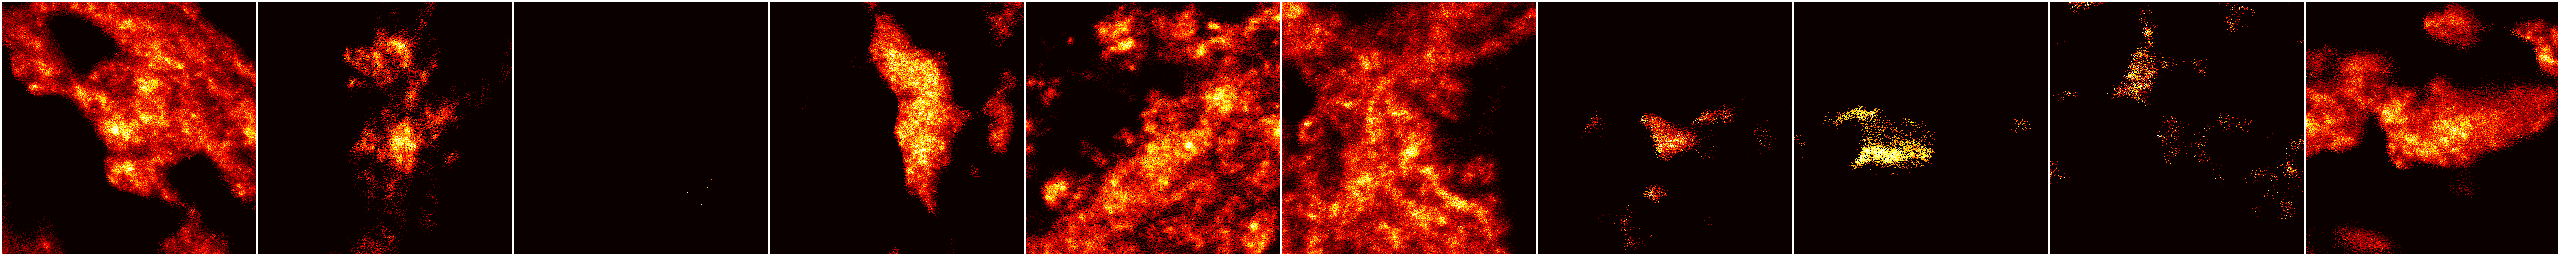

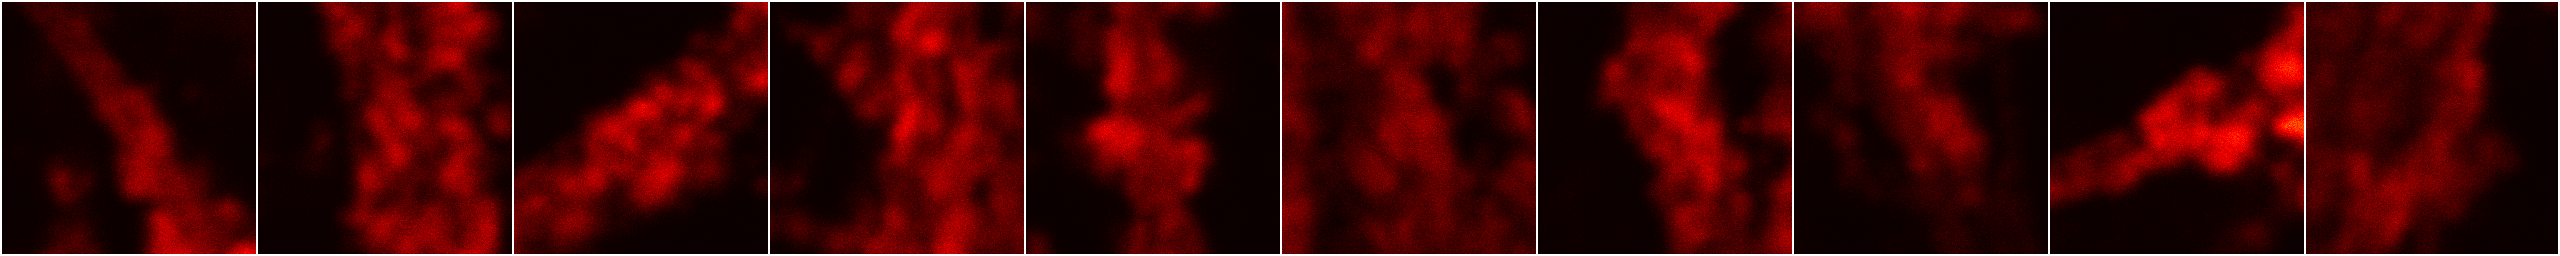

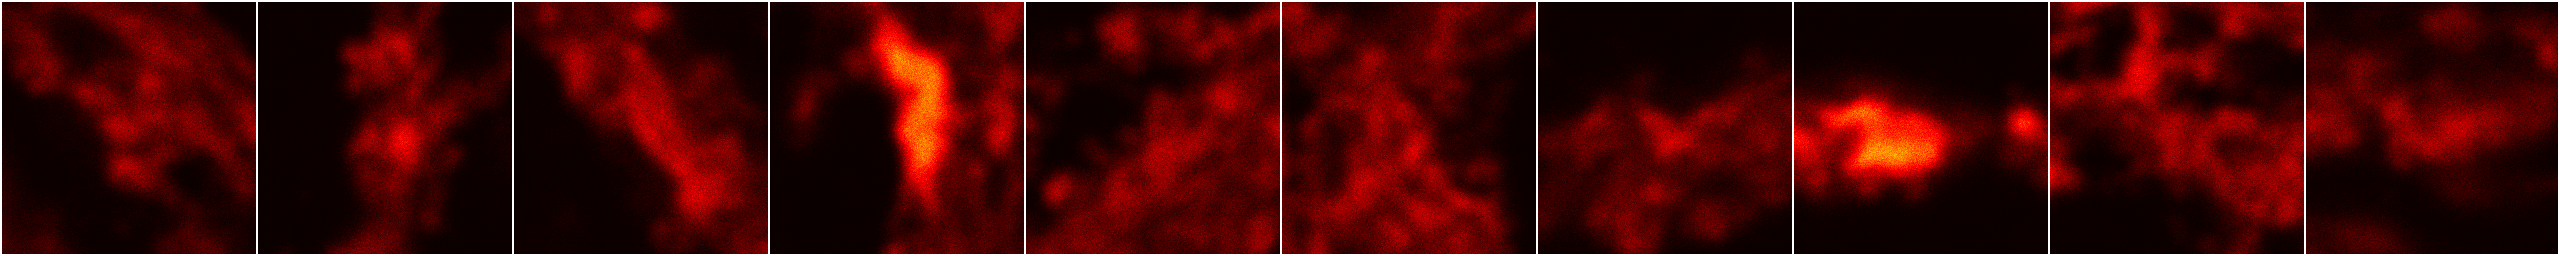

In [37]:
SAVE, SHOW = True, True
MULTIDIM = False
NUM_POINTS = 10
MICROSCOPE = "AbberiorDyMIN_TubulinSTAR635"
model_names_microscope = {
    "AbberiorDyMIN_PSDAlexa594" : [
        "20210804-123707_AbberiorDyMIN_optim_7params_3objectives_degree3"
    ],
    "AbberiorRESCue_PSDAlexa594" : [
        "20210804-112131_AbberiorRESCue_optim_6params_3objectives_degree3"
    ],
    "AbberiorRESCue_TubulinSTAR635" : [
#         "20211015-082816_AbberiorRESCue_optim_6params_3objectives_degree3",
        "20211026-124114_AbberiorRESCue_optim_13params_3objectives_degree3"
    ],
    "AbberiorRESCue_TubulinAlexa647" : [
#         "20211018-062617_AbberiorRESCue_optim_6params_3objectives_degree3",
        "20211026-073444_AbberiorRESCue_optim_6params_3objectives_degree3",
        "20211026-091748_AbberiorRESCue_optim_6params_3objectives_degree3",
        "20211026-111323_AbberiorRESCue_optim_6params_3objectives_degree3",
    ],
    "AbberiorDyMIN_TubulinSTAR635" : [
#         "20211015-092334_AbberiorDyMIN_optim_7params_3objectives_degree3",
        "20211026-135819_AbberiorDyMIN_optim_14params_3objectives_degree3"
    ],
    "AbberiorDyMIN_TubulinAlexa647" : [
#         "20211018-072206_AbberiorDyMIN_optim_7params_3objectives_degree3",
        "20211026-062939_AbberiorDyMIN_optim_7params_3objectives_degree3",
        "20211026-082359_AbberiorDyMIN_optim_7params_3objectives_degree3",
        "20211026-100907_AbberiorDyMIN_optim_7params_3objectives_degree3",
    ],
}
model_names = model_names_microscope[MICROSCOPE]
for i, model_name in enumerate(model_names):
    if not os.path.isdir(os.path.join(PATH, model_name)):
        model_name = glob.glob(os.path.join(PATH, "*", model_name))[0]
        model_name = model_name.split(PATH)[-1][1:]
        model_names[i] = model_name
    
OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 40.,
        "max" : 180.,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 1.,
    },
    "Squirrel" : {
        "min" : 5.,
        "max" : 30.,
    }
}
OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 40.,
        "max" : 350.,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 1.,
    },
    "Squirrel" : {
        "min" : 0.,
        "max" : 2000.,
    }
}
RADAR_OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 0.,
        "max" : 350.,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 1.0,
    },
    "Squirrel" : {
        "min" : 0.,
        "max" : 2000.,
    }
}   

stats = {model_name : {key : defaultdict(list) for key in ["failures", "regressions", "densities", "sequences", "param_sequences"]} for model_name in model_names}
for model_name in model_names:
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))
    is_gridsearch = "gridsearch" in model_name
    N_TRIALS = 1
    for trial in trange(N_TRIALS, desc=model_name, leave=False):
        X, y = load_data(os.path.join(PATH, model_name), trial=trial)
        if (len(X[PARAM_NAMES[0]]) != CONFIG["optim_length"]) and (not "Abberior" in model_name):
            print(f"aborting at trial : {trial}")
            break
            
        # Creation of savepath
        savepath = os.path.join(PATH, model_name, "panels", str(trial))
        os.makedirs(savepath, exist_ok=True)

        # Plots the selection sequence 
        fig, axes = plot_sequence(X, y)
        for obj_name, values in y.items():
            stats[model_name]["sequences"][obj_name].append(values)
        if SAVE and trial==0:
            savefig(fig, axes, os.path.join(savepath, "sequence"), save_white=True)
        if SHOW:
            pyplot.show()
        else:
            pyplot.close("all")
        
        # Gets the parameter selection
        for pname in CONFIG["param_names"]:
            for i in range(NDIMS[CONFIG["param_names"].index(pname)]):
                stats[model_name]["param_sequences"][f"{pname}-{i}"].append(X[pname][:, i])

        # Plots the number of failures
        fig, ax, failures = plot_failures(X, y)
        stats[model_name]["failures"]["failures"].append(failures)
        if SHOW:
            pyplot.show()
        else:
            pyplot.close("all")           
            
#         # Gets the density of points
#         density = get_density(X, num_points=NUM_POINTS)
#         stats[model_name]["densities"]["densities"].append(density)

        if MULTIDIM and trial == 0:
            mapper, X_transformed, fig, ax = plot_umap_points(X, y)
            if SAVE:
                savefig(fig, ax, os.path.join(savepath, "umap-points"), save_white=True)
            if SHOW:
                pyplot.show()
            else:
                pyplot.close("all")

            figaxes = plot_invumap_points(mapper, X_transformed, X, y)
            if SAVE:
                savefig(*figaxes["objectives"], os.path.join(savepath, "invumap-points"), save_white=True)
                for key, (fig, ax) in figaxes["params"].items():
                    savefig(fig, ax, os.path.join(savepath, f"invumap-points-{key}"), save_white=True)
            if SHOW:
                pyplot.show()
            else:
                pyplot.close("all")

            figaxes = plot_invumap_model(X, y)
            if SAVE:
                savefig(*figaxes["objectives"], os.path.join(savepath, "invumap-model"), save_white=True)
                for key, (fig, ax) in figaxes["params"].items():
                    savefig(fig, ax, os.path.join(savepath, f"invumap-model-{key}"), save_white=True)
            if SHOW:
                pyplot.show()
            else:
                pyplot.close("all")

        # Example images
        for image_type in ["conf1", "sted", "conf2"]:
            if os.path.isfile(os.path.join(PATH, model_name, "optim.hdf5")):
                with h5py.File(os.path.join(PATH, model_name, "optim.hdf5")) as file:
                    image_path = file[image_type][f"{trial}"]
                    out_collages = show_N_images(X, y, image_path, ncols=10, 
                                                 vmax=250 if "conf" in image_type else None, 
                                                 image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))
            else:
                image_path = os.path.join(PATH, model_name, image_type, f"{trial}")
                out_collages = show_N_images(X, y, image_path, ncols=10, vmax=None, image_indices=numpy.arange(len(X[PARAM_NAMES[0]])))
            if SHOW:
                for key, col in out_collages.items():
                    display(col)
            if SAVE and (trial == 0):
                for key, col in out_collages.items():
                    col.save(os.path.join(savepath, f"{key}_{image_type}.tif"))

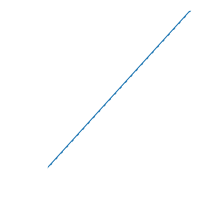

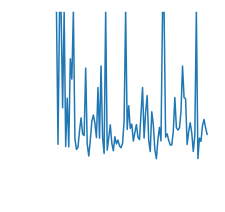

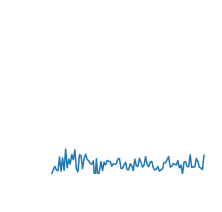

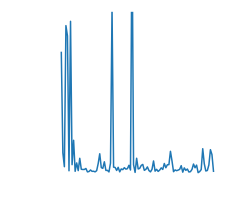

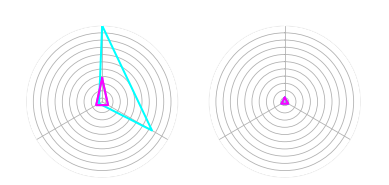

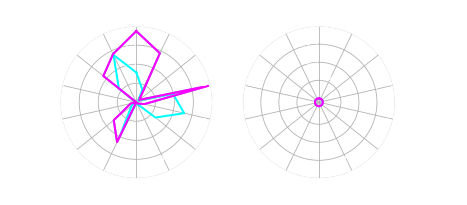

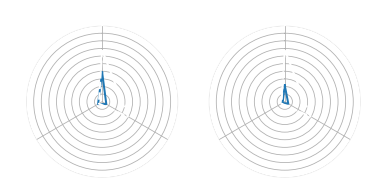

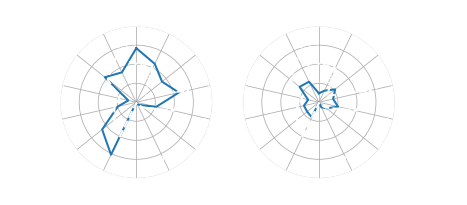

<ipython-input-27-bcd094e27f81>:409: RuntimeWarning: invalid value encountered in true_divide
  ratio = numpy.cumsum(std) / maximal_std_value
<ipython-input-27-bcd094e27f81>:409: RuntimeWarning: invalid value encountered in true_divide
  ratio = numpy.cumsum(std) / maximal_std_value
<ipython-input-27-bcd094e27f81>:409: RuntimeWarning: invalid value encountered in true_divide
  ratio = numpy.cumsum(std) / maximal_std_value
<ipython-input-27-bcd094e27f81>:474: RuntimeWarning: Mean of empty slice.
  distances.append((d.mean(), d.std()))
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountere

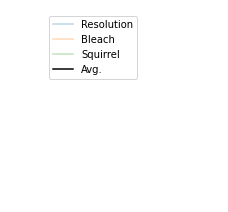

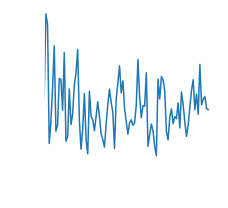

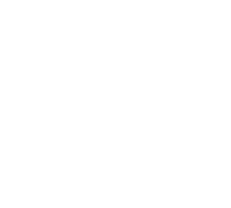

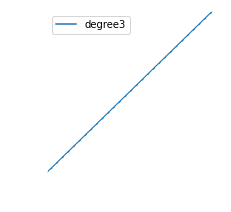

<ipython-input-27-bcd094e27f81>:374: RuntimeWarning: invalid value encountered in true_divide
  ratio = numpy.cumsum(std) / maximal_std_value


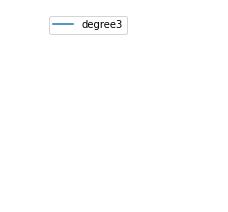

['Resolution', 'Bleach', 'Squirrel']


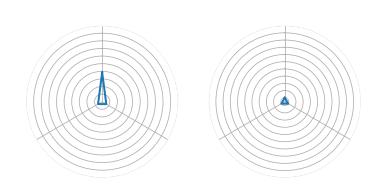

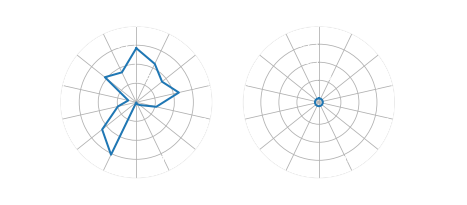

In [32]:
SAVE = True

# Single parameter
os.makedirs("./panels/Nparameters", exist_ok=True)

for model_name in model_names:
    
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))
     
    figaxes = plot_mean_failures(stats[model_name])
    if SAVE:
        for key, (fig,ax) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"{key}"), save_white=True)
    pyplot.show()
    
    figaxes = plot_mean_sequences(stats[model_name])
    if SAVE:
        for key, (fig,ax) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"sequences_{key}"), save_white=True)
    pyplot.show()    
    
    # Plots densities
    for key, values in stats[model_name]["densities"].items():
        param_space = numpy.array([
            numpy.linspace(CONFIG["x_mins"][CONFIG["param_names"].index(pname)], CONFIG["x_maxs"][CONFIG["param_names"].index(pname)], NUM_POINTS) 
            for pname in CONFIG["param_names"] for _ in range(NDIMS[CONFIG["param_names"].index(pname)])
        ])
        
        values = numpy.array(values)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)
        mean, std = mean.reshape([param_space.shape[-1]] * len(param_space)), std.reshape([param_space.shape[-1]] * len(param_space))

        peaks = find_peaks_nd(mean, 0.9)
        if len(peaks) < 1:
            print("No maximum found above threshold")
        else:
            coords = numpy.stack([param_space[i, peaks[:, i]] for i in range(len(param_space))])
            print(CONFIG["param_names"])
            print(coords.T)

    # Plots radar chart
    figaxes = plot_mean_radar_chart(stats[model_name])
    if SAVE:
        for key, (fig, axes) in figaxes.items():
            savefig(fig, axes, os.path.join(PATH, model_name, "panels", f"radar_{key}"), save_white=True)
    pyplot.show()
    
    # Plots model radar chart
    figaxes = plot_model_radar_chart(stats[model_name], nfirst=10, nlast=10)
    if SAVE:
        for key, (fig, axes) in figaxes.items():
            savefig(fig, axes, os.path.join(PATH, model_name, "panels", f"radar_nimages_{key}"), save_white=True)
    pyplot.show()    
    
    fig, ax = plot_mean_cumulative_std(stats[model_name])
    if SAVE:
        savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"cumulative-std"), save_white=True)        
           
    figaxes = plot_mean_param_sequences_dist(stats[model_name])
    if SAVE:
        for key, (fig, ax) in figaxes.items():
            savefig(fig, ax, os.path.join(PATH, model_name, "panels", f"param_sequences_dist_{key}"), save_white=True)
    pyplot.show()
            
# Merge necessary figures 
fig, ax = pyplot.subplots(figsize=(3,3))
for model_name in model_names:
    _ = plot_mean_failures(stats[model_name], figax=(fig, ax))
cmap = pyplot.cm.get_cmap("tab10")
ax.legend(
    handles=[lines.Line2D([], [], color=cmap(i)) for i, (model_name) in enumerate(model_names)],
    labels=[model_name.split("_")[-1] for model_name in model_names],
    loc="upper left"
)
if SAVE:
    savefig(fig, ax, os.path.join("./panels/Nparameters", f"failures_{MICROSCOPE}_{N_TRIALS}"), save_white=True)
pyplot.show()                

fig, ax = plot_cumulative_std(stats)
if SAVE:
    savefig(fig, ax, os.path.join("./panels/Nparameters", f"cumulative-std_{MICROSCOPE}_{N_TRIALS}"), save_white=True)        
pyplot.show()    

figaxes = plot_radar_chart(stats, nlast=10)
if SAVE:
    for key, (fig, axes) in figaxes.items():
        savefig(fig, axes, os.path.join("./panels/Nparameters", f"radar_{key}_{MICROSCOPE}_{N_TRIALS}"), save_white=True)
pyplot.show()    

# Debug

In [ ]:
SAVE = True
MICROSCOPE = "DyMIN"
model_names_microscope = {
    "DyMIN" : [
        "20210701-071757_DyMIN_prefnet_1params_3objectives_degree4", # (4, 2)
        "20210701-071843_DyMIN_prefnet_1params_3objectives_degree3", # (4, 2)
        "20210701-071919_DyMIN_prefnet_1params_3objectives_degree2", # (4, 2)
#         "20210623-105256_DyMIN_prefnet_1params_3objectives_degree4", # (10, 5)
#         "20210630-061632_DyMIN_prefnet_1params_3objectives_degree3", # (10, 5)
#         "20210630-160821_DyMIN_prefnet_1params_3objectives_degree2", # (10, 5)
    ],
    "RESCue" : [
        "20210623-133229_RESCue_prefnet_1params_3objectives_degree4",
        "20210630-061632_RESCue_prefnet_1params_3objectives_degree3",
        "20210630-160824_RESCue_prefnet_1params_3objectives_degree2"        
    ],
    "Human" : [
        "20210618-145645_optim_1params_3objectives_degree4"
    ]
}
model_names = model_names_microscope[MICROSCOPE]
param_name = "p_sted"

allX, ally = [], {obj_name : [] for obj_name in ["Resolution", "Bleach", "Squirrel"]}
for model_name in model_names:
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))
    
    Xs = numpy.linspace(*PARAM_SPACE_BOUNDS[0], N_POINTS[0])
    for trial in trange(N_TRIALS, desc=model_name, leave=False):
        X, y = load_data(os.path.join(PATH, model_name), trial=trial)
        
        allX.extend(X[param_name])
        for obj_name, values in y.items():
            ally[obj_name].extend(values)
allX = numpy.array(allX)
ally = {obj_name : numpy.array(values) for obj_name, values in ally.items()}

ratios = []
for _x in Xs:
    where = (allX == _x).ravel()
    
    in_bounds = []
    for obj_name, values in ally.items():
        in_bounds.append(isin_bounds(values[where], obj_name))
    in_bounds = numpy.sum(numpy.all(in_bounds, axis=0))
    
    ratios.append(
        1 - (in_bounds / (numpy.sum(where) + 1e-9))
    )
fig, ax = pyplot.subplots(figsize=(3,3))
ax.bar(Xs, ratios, width=numpy.mean(numpy.diff(Xs)))
ax.set(
    ylim=(0, 1), ylabel="Failures (%)"
)
if SAVE:
    fig.savefig(f"./panels/1parameters/failures-vs-parameter_{MICROSCOPE}.pdf", transparent=True, bbox_inches="tight")
pyplot.show()

# Plot all points
for obj_name, values in ally.items():
    fig, ax = pyplot.subplots(figsize=(3,3))
    
    mean = []
    for _x in Xs:
        where = (allX == _x).ravel()
        mean.append(numpy.mean(values[where]))
    index = numpy.random.choice(len(allX), size=(2500,), replace=False)
    ax.scatter(allX[index], values[index], alpha=0.3)
    ax.plot(Xs, mean, color="white", linewidth=2, linestyle="dashed")
    ax.set(
        xlabel=param_name, ylabel=obj_name
    )
    change_figax_color(fig, ax)    
    if SAVE:
        fig.savefig(f"./panels/1parameters/raw-points_{MICROSCOPE}_{obj_name}.pdf", transparent=True, bbox_inches="tight", dpi=600)
pyplot.show()

## Weights evolution

In [ ]:
MICROSCOPE = "DyMIN"
model_names = model_names_microscope[MICROSCOPE]
param_name = "p_sted"
stats = {model_name : {key : defaultdict(list) for key in ["failures", "regressions", "densities", "sequences", "weights"]} for model_name in model_names}
for model_name in model_names:
    CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS, N_TRIALS = load_config(os.path.join(PATH, model_name))
#     N_TRIALS = 3
    for trial in trange(N_TRIALS, desc=model_name, leave=False):
        X, y = load_data(os.path.join(PATH, model_name), trial=trial)
        
        for obj_name, values in y.items():
            
            args = CONFIG["regressor_args"]["default"].copy()
            args["param_space_bounds"] = PARAM_SPACE_BOUNDS
            for key, value in CONFIG["regressor_args"][obj_name].items():
                args[key] = value
            sampler = algorithms.TS_sampler(REGRESSORS_DICT[CONFIG["regressor_name"]](**args))

            coefs = []
            for i in range(1, len(X[param_name])):
                sampler.update(X[param_name][:i], scale_obj(values[:i], obj_name))
                coefs.append(sampler.regressor.coef_)
            coefs = numpy.array(coefs)
            
            stats[model_name]["weights"][obj_name].append(coefs)
            


In [ ]:
for model_name in model_names:
    
    for obj_name in ["Resolution", "Bleach", "Squirrel"]:
        coefs = stats[model_name]["weights"][obj_name]
        coefs = numpy.array(coefs)

        mean, std = numpy.mean(coefs, axis=0), numpy.std(coefs, axis=0)
        
        fig, ax = pyplot.subplots(figsize=(3,3))
        for m, s in zip(mean.T, std.T):
            x_ = numpy.arange(len(m))
            ax.plot(x_, m)
            ax.fill_between(x_, m - s, m + s, alpha=0.3)
        ax.set(title=obj_name, xlim=(0,CONFIG["optim_length"]))            
        pyplot.show()
        
        fig, ax = pyplot.subplots(figsize=(3,3))
        for c in mean.T:
            delta = 5
            c_ = [numpy.std(c[i - delta : i + delta]) for i in range(delta, len(c) - delta + 1)]
            r_ = numpy.arange(delta, len(c) - delta + 1)
            ax.plot(r_, c_)
        ax.set(title=obj_name, xlim=(0,CONFIG["optim_length"]))
        pyplot.show()

In [ ]:
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
    
    # For line plots
    for line in ax.get_lines():
        if line.get_color() in ["#000000", "000000", "black"]:
            line.set_color("white")    

    # For scatter plots
    for collection in ax.collections:
        new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                         for c in collection.get_facecolors()]
        collection.set_facecolors(new_colors)
        new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                         for c in collection.get_edgecolors()]        
        collection.set_edgecolors(new_colors)

    # For hist plots
    for patch in ax.patches:
        c = patch.get_facecolor()
        if matplotlib.colors.to_hex(c) == "#000000":
            patch.set_color("white")
    
fig,ax = pyplot.subplots()
ax.scatter([0, 0, 0], [0, 1, 2], c=[0.1, 0.3, 0.5], cmap="magma", edgecolor="black")
change_figax_color(fig, axes)

pyplot.show()

In [ ]:

N = 50
for model_name in model_names:
    print(model_name)

    figaxes = plot_radar_chart(stats[model_name])
    for key, (fig, axes) in figaxes.items():
        change_figax_color(fig, axes)

        pyplot.show()

# Cumulative STD

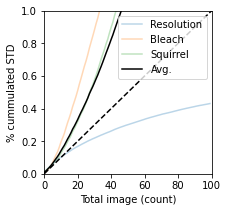

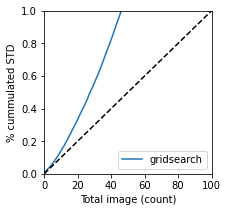

In [197]:
def plot_mean_cumulative_std(stats):
    """
    Plots the average cumulative std from a model on the different 
    objectives
    
    :param stats: A `dict` of statisitics
    
    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
    """
    fig, ax = pyplot.subplots(figsize=(3,3))
    for model_name, model_stats in stats.items():        
        ratios = []
        for i, (obj_name, values) in enumerate(model_stats["sequences"].items()):
            values = numpy.array(values)
            values = scale_obj(values, obj_name=obj_name)
            mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)
            # Represents the cummulated value of STD if agent did not learn
            maximal_std_value = numpy.mean(std[:5]) * len(std)
            ratio = numpy.cumsum(std) / maximal_std_value
            ratios.append(ratio)
        
        ratio = numpy.mean(ratios, axis=0)
        ax.plot(ratio, label=model_name.split("_")[-1])
    ax.plot([0, CONFIG["optim_length"]], [0, 1], color="black", linestyle="dashed")        
    ax.set(
        ylim=(0, 1), xlim=(0, CONFIG["optim_length"]),
        xlabel="Total image (count)",
        ylabel="% cummulated STD"
    )
    ax.legend()    
    return fig, ax
    
def plot_cumulative_std(stats):
    """
    Plots the average cumulative std of the different models 
    on the same graph
    
    :param stats: A `dict` of statisitics
    
    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
    """    
    fig, ax = pyplot.subplots(figsize=(3,3))
    cmap = pyplot.cm.get_cmap("tab10")
    ratios = []
    for i, (obj_name, values) in enumerate(stats["sequences"].items()):
        
        values = numpy.array(values)
        values = scale_obj(values, obj_name=obj_name)
        mean, std = numpy.mean(values, axis=0), numpy.std(values, axis=0)
    
        # Represents the cummulated value of STD if agent did not learn
        maximal_std_value = numpy.mean(std[:5]) * len(std)
        ratio = numpy.cumsum(std) / maximal_std_value
        ax.plot(ratio, label=obj_name, color=cmap(i), alpha=0.3)
        ratios.append(ratio)
    ax.plot([0, CONFIG["optim_length"]], [0, 1], color="black", linestyle="dashed")
    ax.plot(numpy.mean(ratios, axis=0), color="black", linestyle="solid", label="Avg.")
    ax.set(
        ylim=(0, 1), xlim=(0, CONFIG["optim_length"]),
        xlabel="Total image (count)",
        ylabel="% cummulated STD"
    )
    ax.legend()
    return fig, ax
    
for model_name in model_names:

    plot_cumulative_std(stats[model_name])
    
    pyplot.show()

plot_mean_cumulative_std(stats)
pyplot.show()

# Parameter selection distance

<ipython-input-97-3ace58d34129>:58: RuntimeWarning: invalid value encountered in true_divide
  mean, std = mean / mean[0], std / mean[0]


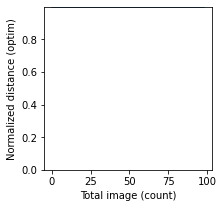

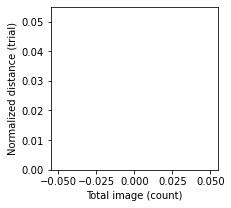

In [97]:
def dist(x, y):
    """
    Calculates the distance between `x` and `y` in n-dimensions
    
    :param x: A `numpy.ndarray` of size (M, n)
    :param y: A `numpy.ndarray` of size (M, n)
    
    :returns A `numpy.ndarray` of the size (M)
    """
    x, y = map(numpy.array, (x, y))
    if x.ndim == 1: 
        x = x[:, numpy.newaxis]
    if y.ndim == 1:
        y = y[:, numpy.newaxis]
    return numpy.sqrt(numpy.sum((x - y) ** 2, axis=1))
    
def plot_mean_param_sequences_dist(stats):
    """
    Plots the selected distances between two sampled parameters
    
    :param stats: A `dict` of the stats
    """
    out = {}
    
    values = numpy.array([values for key, values in stats["param_sequences"].items()])
    
    distances = []
    for i in range(values.shape[-1] - 1):
        dataA = values[:, :, i].T
        dataB = values[:, :, i + 1].T
        distances.append(dist(dataA, dataB))
    distances = numpy.array(distances)
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    mean, std = numpy.mean(distances, axis=1), numpy.std(distances, axis=1)
    mean, std = mean / (mean[0] + 1e-9), std / (mean[0] + 1e-9)
    x = numpy.arange(len(mean))
    ax.plot(x, mean)
    ax.fill_between(x, mean - std, mean + std, alpha=0.3)
    ax.set(
        xlabel="Total image (count)", ylabel="Normalized distance (optim)",
        ylim=(0, None), xlim=(0, CONFIG["optim_length"])
    )
    out["optim"] = (fig, ax)
    
    distances = []
    for i in range(values.shape[-1]):
        dataA = values[:, :, i].T
        d = distance.cdist(dataA, dataA)
#         distances.append
        mask = ~numpy.eye(d.shape[0], dtype=bool) # everything apart from diagonal
        d = d[mask]
        distances.append((d.mean(), d.std()))
    distances = numpy.array(distances)    
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    mean, std = distances[:, 0], distances[:, 1]
    mean, std = mean / mean[0], std / mean[0]
    x = numpy.arange(len(mean))
    ax.plot(x, mean)
    ax.fill_between(x, mean - std, mean + std, alpha=0.3)
    ax.set(
        xlabel="Total image (count)", ylabel="Normalized distance (trial)",
        ylim=(0, None)
    )    
    out["trial"] = (fig, ax)
    return out
    
# for model_name in model_names:
#     figaxes = plot_mean_param_sequences_dist(stats[model_name])
    
# pyplot.show()
